# True & Fake Job Classification with NLP

## Importing Libraries

In [ ]:
#importing all the required libraries & mounting google drive.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
import nltk as nlp
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk_stops_words = nltk.corpus.stopwords.words('english')
lemma = nlp.WordNetLemmatizer()
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,pair_confusion_matrix,classification_report
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA,TruncatedSVD
from tensorflow import keras
from collections import Counter
import plotly.express as px
import gensim
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertModel
import torch
from keras.layers import Bidirectional,Dropout
from nltk import ngrams
from nltk.util import bigrams
from collections import Counter
from nltk import pos_tag
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('stopwords')



from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Dataset

In [ ]:
#importing data into dataframe
df_fake_job_pos_og = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IST 664/Project/fake_job_postings.csv')
df_syn_fake_job_pos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IST 664/Project/synthetic_dataset.csv')

In [ ]:
#checking shape and number of columns
df_fake_job_pos_og.shape

(17880, 18)

In [ ]:
#Checking shape for synthetic data we generated from Gretel
df_syn_fake_job_pos.shape

(5000, 18)

In [ ]:
#Checking data type and data present in the columns
df_fake_job_pos_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
#Checking info for synthetic data
df_syn_fake_job_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               5000 non-null   int64 
 1   title                5000 non-null   object
 2   location             4271 non-null   object
 3   department           1769 non-null   object
 4   salary_range         1633 non-null   object
 5   company_profile      1521 non-null   object
 6   description          5000 non-null   object
 7   requirements         4995 non-null   object
 8   benefits             5000 non-null   object
 9   telecommuting        5000 non-null   int64 
 10  has_company_logo     5000 non-null   int64 
 11  has_questions        5000 non-null   int64 
 12  employment_type      3912 non-null   object
 13  required_experience  2633 non-null   object
 14  required_education   2819 non-null   object
 15  industry             4050 non-null   object
 16  functi

#### Mergeing Datasets

In [ ]:
#Merging both datasets
df_fake_job_pos = pd.concat([df_fake_job_pos_og, df_syn_fake_job_pos], axis=0, ignore_index=True)

## Exploratory Data Analysis (EDA)

### Distribution of the Target Variable (Posting is Fake or Not)

0    17014
1      866
Name: fraudulent, dtype: int64


<Axes: xlabel='fraudulent', ylabel='count'>

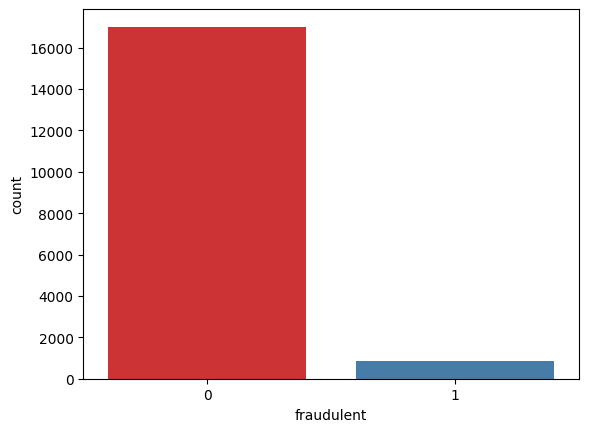

In [ ]:
##  Distribution of Target Variable in the original Dataset
## Here '0' stands for Job Posting is genuiue and '1' is fake
print(df_fake_job_pos_og['fraudulent'].value_counts())
# Distribution of fraudulent jobs
sns.countplot(x='fraudulent', data=df_fake_job_pos_og)

1    5000
Name: fraudulent, dtype: int64


<Axes: xlabel='fraudulent', ylabel='count'>

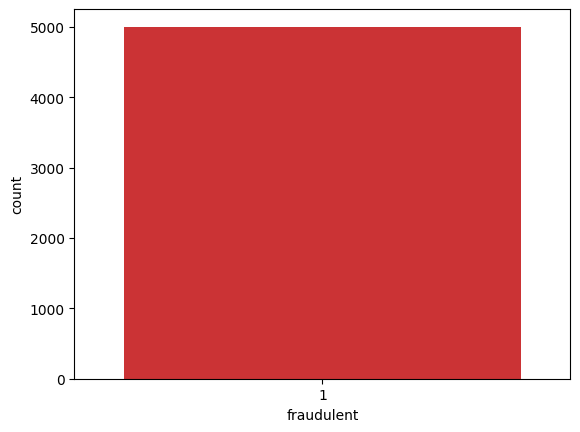

In [ ]:
##  Distribution of Target Variable in the synthetic dataset
## Here '0' stands for Job Posting is genuiue and '1' is fake
print(df_syn_fake_job_pos['fraudulent'].value_counts())
# Distribution of fraudulent jobs
sns.countplot(x='fraudulent', data=df_syn_fake_job_pos)

0    17014
1     5866
Name: fraudulent, dtype: int64


<Axes: xlabel='fraudulent', ylabel='count'>

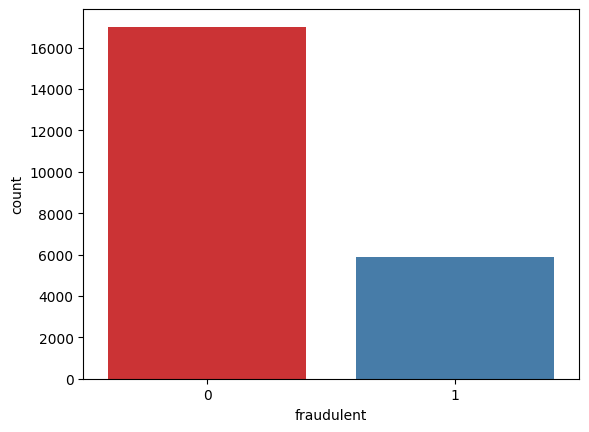

In [ ]:
##  Distribution of Target Variable in merged dataset
## Here '0' stands for Job Posting is genuiue and '1' is fake
print(df_fake_job_pos['fraudulent'].value_counts())
# Distribution of fraudulent jobs
sns.countplot(x='fraudulent', data=df_fake_job_pos)

### Missing Values

In [ ]:
#checing number of data missing columnwise.
df_fake_job_pos.isnull().sum()

job_id                     0
title                      0
location                1075
department             14778
salary_range           18379
company_profile         6787
description                1
requirements            2700
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         4559
required_experience     9417
required_education     10286
industry                5853
function                7829
fraudulent                 0
dtype: int64

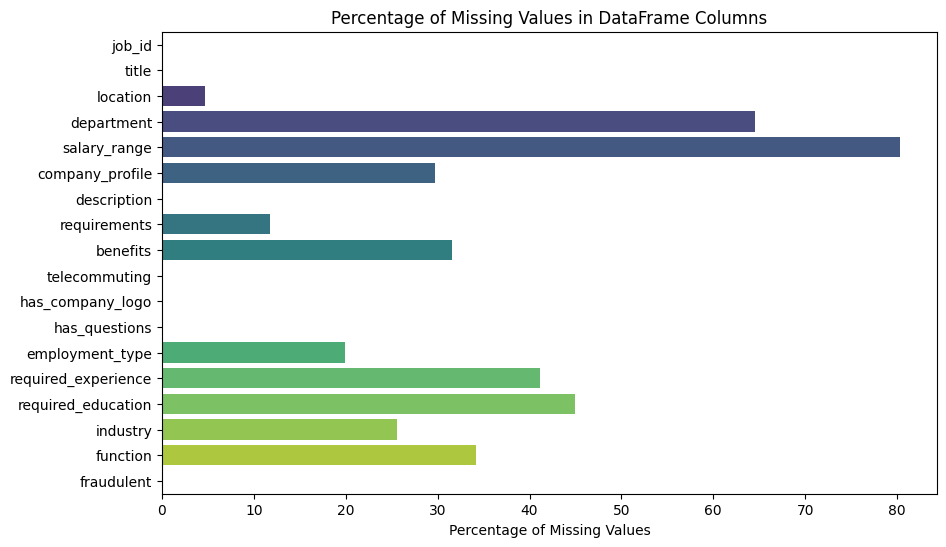

In [ ]:
#missing value percentages for each column
missing_percentage = df_fake_job_pos.isnull().mean() * 100

#bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette='viridis')
plt.xlabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in DataFrame Columns')
plt.show()

The dataset has several missing entries spread across multiple columns, notably affecting crucial fields such as 'location,' 'department,' 'salary_range,' 'company_profile,' 'requirements,' 'benefits,' 'employment_type,' 'required_experience,' 'required_education,' 'industry,' and 'function.' These omissions could stem from various factors, including voluntary non-disclosure, unspecified information, or simply lapses in the job listings. The diversity in missing data across these categories implies several possible explanations for the absence of information in this dataset.








### Employement Type

Full-time    14931
Contract      1762
Part-time     1054
Other          308
Temporary      266
Name: employment_type, dtype: int64


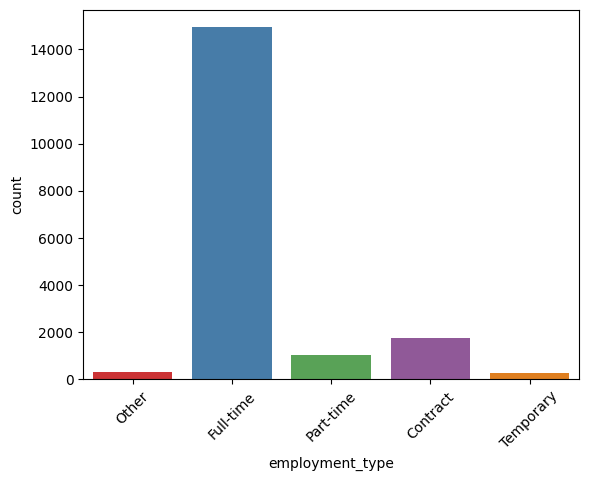

In [ ]:
#countplot for emp_type
print(df_fake_job_pos['employment_type'].value_counts())
sns.countplot(x='employment_type', data=df_fake_job_pos)
plt.xticks(rotation=45)
plt.show()

The 'employment_type' column predominantly consists of 'Full-time' positions with 14,931 entries, followed by 'Contract' with 1,762, 'Part-time' with 1,054, 'Other' with 308, and 'Temporary' with 266 entries.

### Locations

In [ ]:
#checking job posting by locations.
print(df_fake_job_pos['location'].value_counts())

US, NJ, NEWARK           1107
GB, LND, London           718
US, NY, New York          658
US, CA, San Francisco     521
US, TX, Houston           518
                         ... 
US, , Woodinville           1
ID, , Medan                 1
NL, NH, Amsetrdam           1
US, OH, West Chester        1
GB, WSX, Chichester         1
Name: location, Length: 3105, dtype: int64


US    14660
GB     2399
GR      940
CA      539
DE      383
NZ      333
IN      276
AU      214
PH      132
MY      129
Name: location, dtype: int64


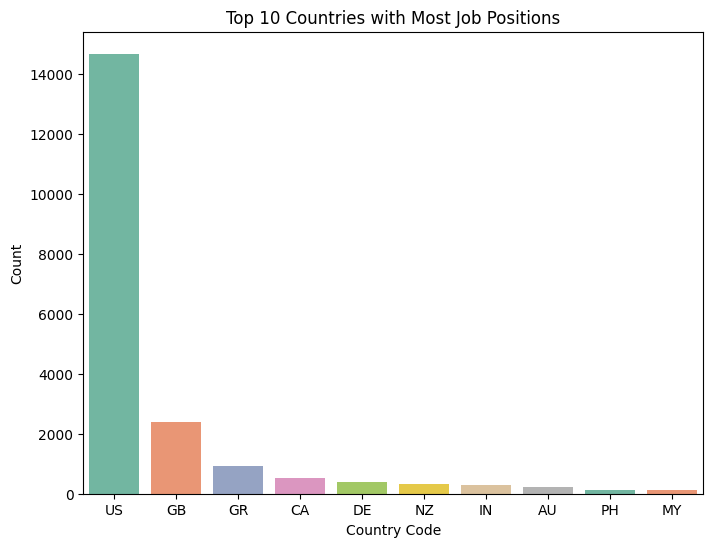

In [ ]:
#as there are multiple formats of data we are extracting the country from the data and plotting it.
#value counts for the first two characters in 'location' column
top_countries = df_fake_job_pos['location'].str[:2].value_counts().nlargest(10)
print(top_countries)
#plotting the count of top 10 countries
plt.figure(figsize=(8, 6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='Set2')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.title('Top 10 Countries with Most Job Positions')
plt.show()

The data displays the count of job postings by country. The top countries with the highest number of job postings are the United States (14660), followed by the United Kingdom (2399) and Greece (940). Countries like Canada (539), Germany (383), and New Zealand (333) also feature in the list, albeit with lower posting counts. This information offers insight into the distribution of job postings across different countries within the dataset.

### Salary Range

0-0             160
30000-50000      88
30000-40000      86
40000-50000      82
25000-30000      60
35000-40000      53
23000-28000      53
28000-32000      50
40000-45000      49
7200-1380000     48
Name: salary_range, dtype: int64


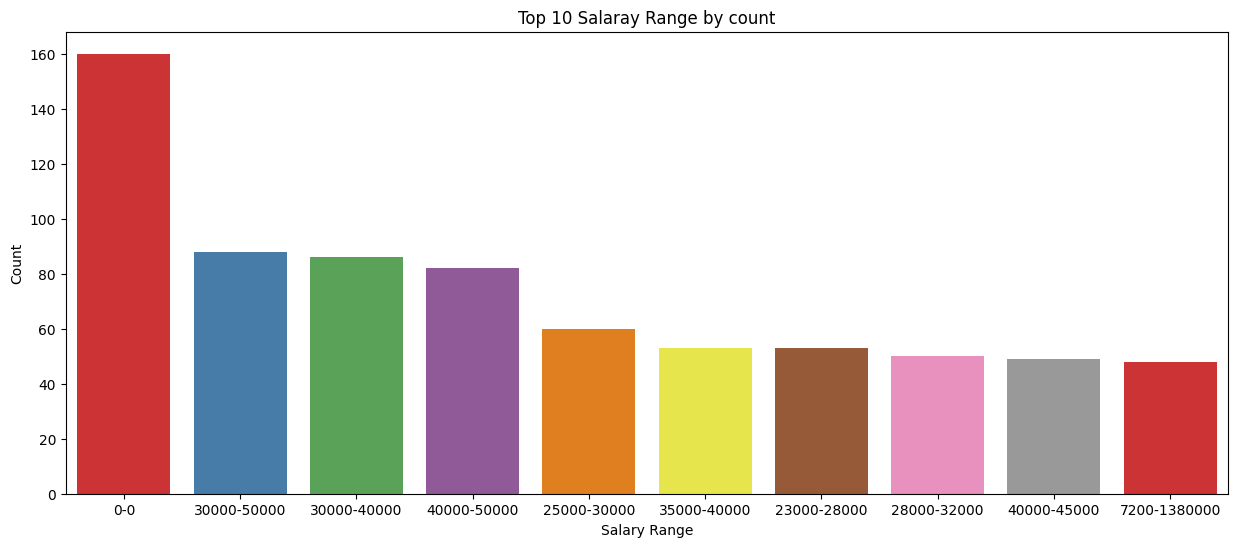

In [ ]:
sal_rage_top10 = df_fake_job_pos['salary_range'].value_counts().nlargest(10)
print(sal_rage_top10)
#plotting the count of top 10 countries
plt.figure(figsize=(15, 6))
sns.barplot(x=sal_rage_top10.index, y=sal_rage_top10.values, palette='Set1')
plt.xlabel('Salary Range')
plt.ylabel('Count')
plt.title('Top 10 Salaray Range by count')
plt.show()

360000-400000    1
208000-270400    1
70000-200000     1
600000-840000    1
1300-1500        1
90000-115000     1
16000-19000      1
27000-34280      1
45000-120000     1
40000-85000      1
Name: salary_range, dtype: int64


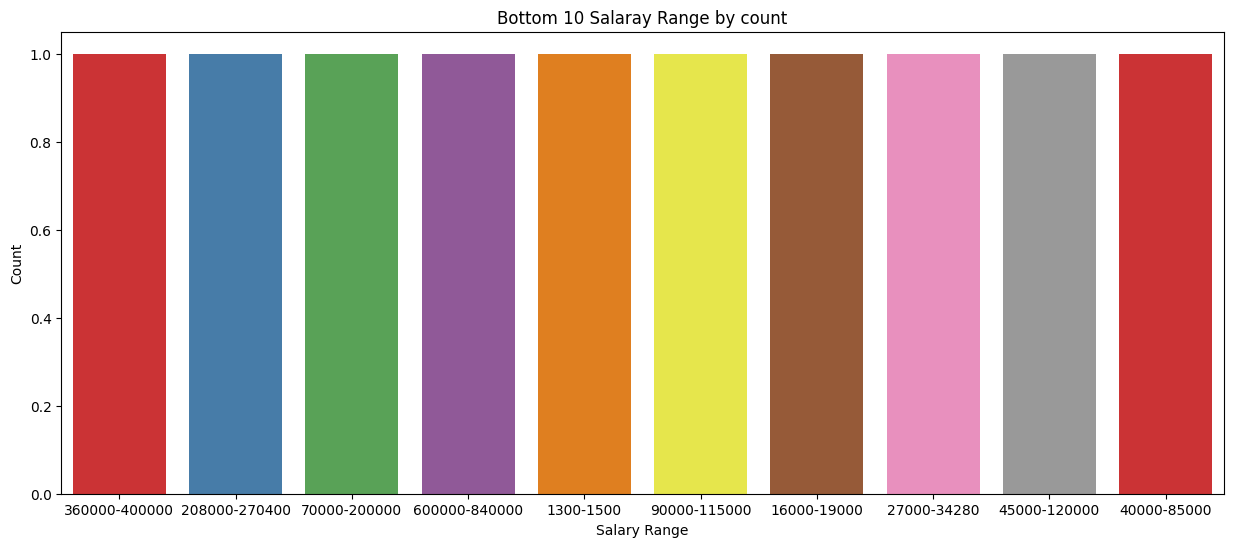

In [ ]:
sal_rage_bottom10 = df_fake_job_pos['salary_range'].value_counts().nsmallest(10)
print(sal_rage_bottom10)
#plotting the count of top 10 countries
plt.figure(figsize=(15, 6))
sns.barplot(x=sal_rage_bottom10.index, y=sal_rage_bottom10.values, palette='Set1')
plt.xlabel('Salary Range')
plt.ylabel('Count')
plt.title('Bottom 10 Salaray Range by count')
plt.show()

### Industry

<ipython-input-114-02cebe7bbe24>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_counts_combined = top_10.append(pd.Series(other_count, index=['Others']))


([<matplotlib.patches.Wedge at 0x7c932e4403a0>,
 [Text(-1.0355308724480516, 0.37104691375482024, 'Information Technology and Services'),
  Text(-1.059938788852639, -0.2941594191685878, 'Computer Software'),
  Text(-0.7853191839418997, -0.7702426756112835, 'Oil & Energy'),
  Text(-0.3686576275070983, -1.0363838833563739, 'Marketing and Advertising'),
  Text(0.06951160212169429, -1.09780150171626, 'Internet'),
  Text(0.4567457834039401, -1.0006914056504739, 'Financial Services'),
  Text(0.7488852138105995, -0.8057114474399956, 'Education Management'),
  Text(0.9489594387978564, -0.5563056565562295, 'Hospital & Health Care'),
  Text(1.0591997627912704, -0.2968094717203561, 'Accounting'),
  Text(1.0975367680925343, -0.07357338299272878, 'Telecommunications'),
  Text(0.3646393671861446, 1.0378044767190437, 'Others')],
 [Text(-0.5648350213353008, 0.20238922568444737, '11.3%'),
  Text(-0.5781484302832576, -0.16045059227377514, '8.3%'),
  Text(-0.4283559185137635, -0.4201323685152455, '7.8%'),

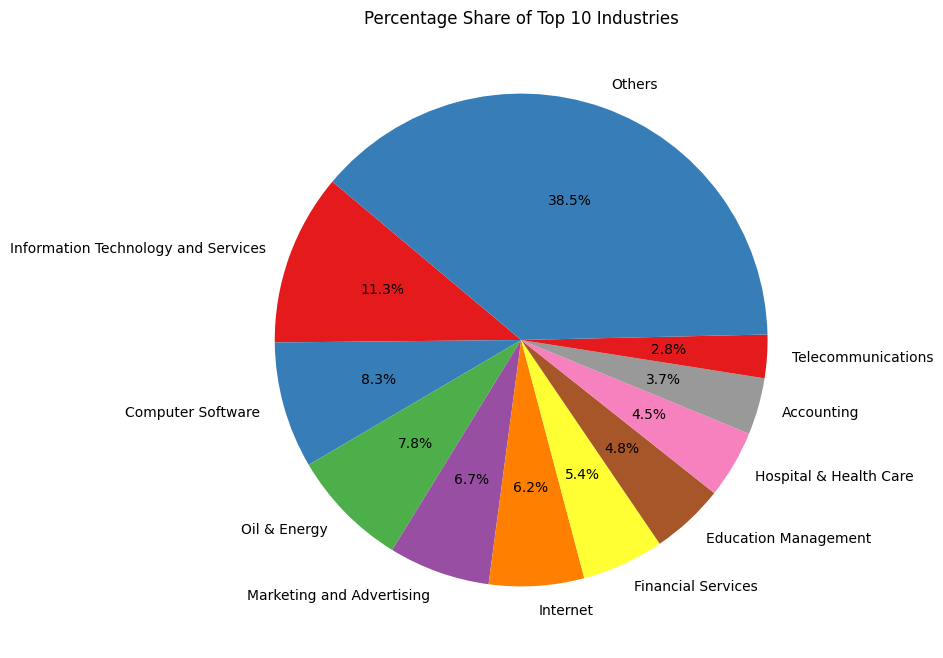

In [ ]:
#value counts for the 'industry' column
industry_counts = df_fake_job_pos['industry'].value_counts()

#top 10 industries and aggregate the rest as 'Others'
top_10 = industry_counts.nlargest(10)
other_count = industry_counts[~industry_counts.index.isin(top_10.index)].sum()
industry_counts_combined = top_10.append(pd.Series(other_count, index=['Others']))
percentage_share = industry_counts_combined / industry_counts_combined.sum() * 100

#Plotting
plt.figure(figsize=(10, 8))
sns.set_palette('Set1')
plt.title('Percentage Share of Top 10 Industries')
plt.pie(percentage_share, labels=percentage_share.index, autopct='%1.1f%%', startangle=140)


The pie chart above illustrates the top 10 industries based on job postings, while all other industries have been grouped together and labeled as 'others'.

### Education

Bachelor's Degree                    6170
High School or equivalent            3036
Unspecified                          1668
Master's Degree                       604
Associate Degree                      341
Certification                         265
Some College Coursework Completed     144
Some High School Coursework           140
Professional                          114
Vocational                             49
Doctorate                              48
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64


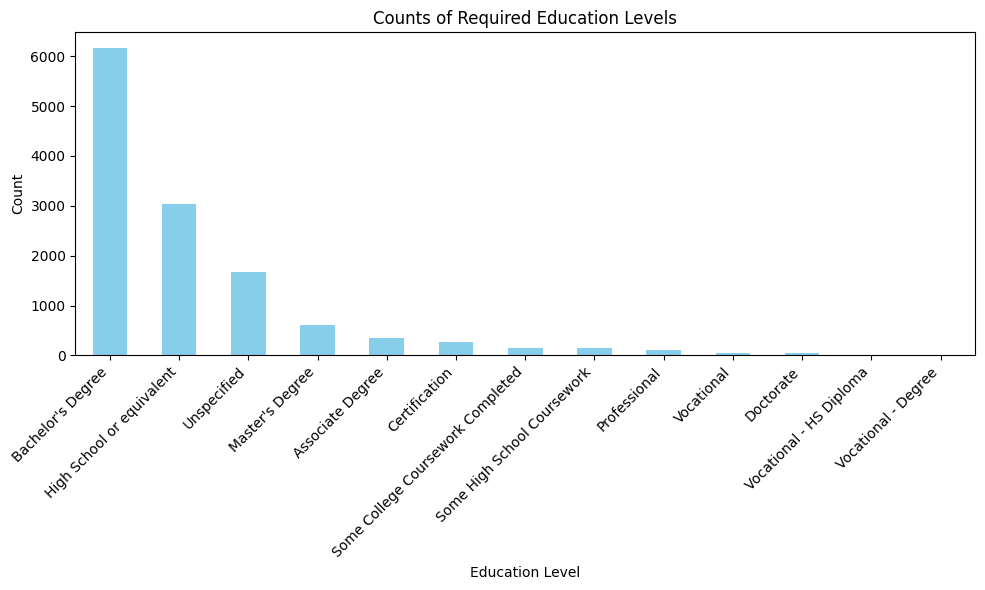

In [ ]:
# Get value counts for 'required_education' column
education_counts = df_fake_job_pos['required_education'].value_counts()
print(education_counts)

# Plotting the value counts / bar graph
plt.figure(figsize=(10, 6))
education_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Counts of Required Education Levels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Experience

Mid-Senior level    4307
Entry level         4130
Associate           2504
Not Applicable      1403
Director             484
Internship           443
Executive            192
Name: required_experience, dtype: int64


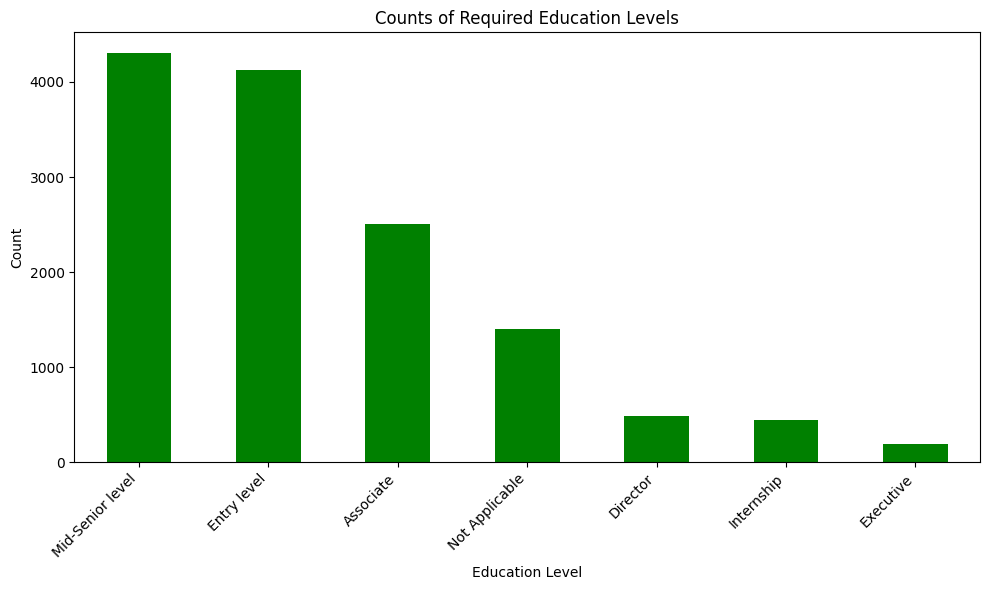

In [ ]:
#value counts for 'required_education' column
education_counts = df_fake_job_pos['required_experience'].value_counts()
print(education_counts)

#plotting the value counts / bar graph
plt.figure(figsize=(10, 6))
education_counts.plot(kind='bar', color='green')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Counts of Required Education Levels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


This table showcases the count of different education levels in job postings. The data reveals various levels, with the majority consisting of 'Bachelor's Degree' and 'High School or equivalent'. There are also entries labeled as 'Unspecified', indicating missing or unspecified education details. Data correction is required for 'Vocational - HS Diploma' and 'Vocational - Degree', which could be grouped under 'Vocational'. Additionally, similar educational backgrounds like 'Bachelor's Degree' and 'Master's Degree' could be grouped together for better categorization.

### Job Role Function

In [ ]:
#role values
print(df_fake_job_pos['function'].value_counts())

Customer Service          2048
Information Technology    2021
Engineering               1732
Sales                     1695
Administrative            1396
Marketing                  887
Accounting/Auditing        459
Other                      458
Design                     364
Management                 363
Health Care Provider       349
Education                  338
Business Development       315
Finance                    280
Human Resources            267
Project Management         238
Consulting                 174
Art/Creative               152
Writing/Editing            132
Advertising                130
Data Analyst               126
Production                 116
Product Management         114
Quality Assurance          111
Business Analyst           102
Financial Analyst           98
Manufacturing               92
Public Relations            86
General Business            81
Strategy/Planning           72
Distribution                55
Research                    50
Legal   

<ipython-input-118-02ef78f6b63d>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  function_counts_combined = top_10.append(pd.Series(other_count, index=['Others']))


([<matplotlib.patches.Wedge at 0x7c932e360340>,
 [Text(-1.0599561547871637, 0.29409683767223727, 'Customer Service'),
  Text(-0.9209106999157554, -0.6016007669382358, 'Information Technology'),
  Text(-0.2279767134698344, -1.0761164519305024, 'Engineering'),
  Text(0.5336820770026288, -0.9618645646275573, 'Sales'),
  Text(1.0048190279025995, -0.4475921370677497, 'Administrative'),
  Text(1.0981839450803077, 0.06318245617140998, 'Marketing'),
  Text(1.0376082226839487, 0.3651974482641649, 'Accounting/Auditing'),
  Text(0.949184606975276, 0.5559213810254029, 'Other'),
  Text(0.8403322329680497, 0.7098181022169917, 'Design'),
  Text(0.7233760430381995, 0.8286899905021161, 'Management'),
  Text(-0.126650567786702, 1.092684599360358, 'Others')],
 [Text(-0.5781579026111802, 0.16041645691212938, '13.6%'),
  Text(-0.5023149272267756, -0.32814587287540137, '13.4%'),
  Text(-0.12435093461990965, -0.5869726101439103, '11.5%'),
  Text(0.2910993147287066, -0.5246533988877584, '11.3%'),
  Text(0.548

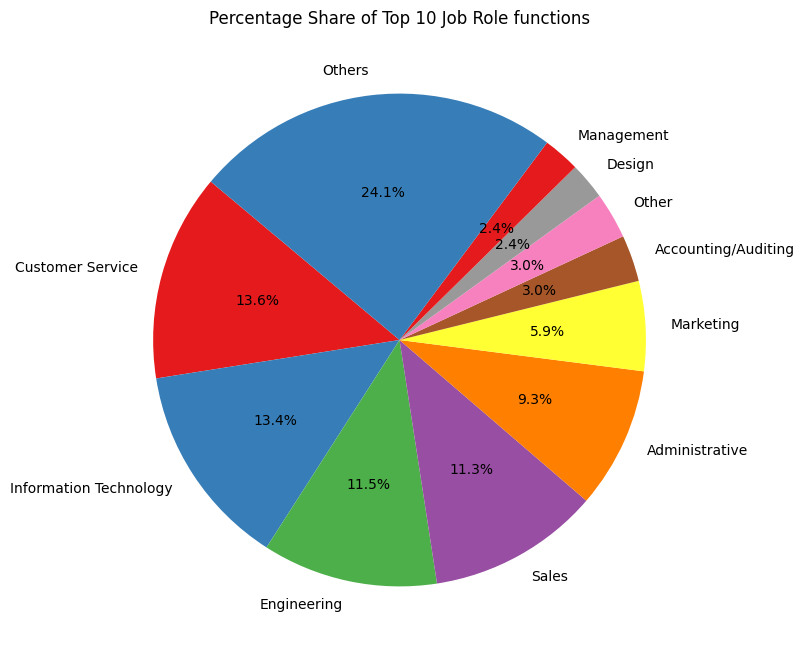

In [ ]:
#calculate value counts for the 'industry' column
function_counts = df_fake_job_pos['function'].value_counts()

#select top 10 industries and aggregate the rest as 'Others'
top_10 = function_counts.nlargest(10)
other_count = function_counts[~function_counts.index.isin(top_10.index)].sum()
function_counts_combined = top_10.append(pd.Series(other_count, index=['Others']))
percentage_share = function_counts_combined / function_counts_combined.sum() * 100

#Plot
plt.figure(figsize=(10, 8))
sns.set_palette('Set1')
plt.title('Percentage Share of Top 10 Job Role functions')
plt.pie(percentage_share, labels=percentage_share.index, autopct='%1.1f%%', startangle=140)


The pie chart above displays the top 10 job roles in the dataset, while the remaining roles are combined into an 'other' category.

### Correlation Matrix

<ipython-input-119-519dc695e9aa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_fake_job_pos.corr()


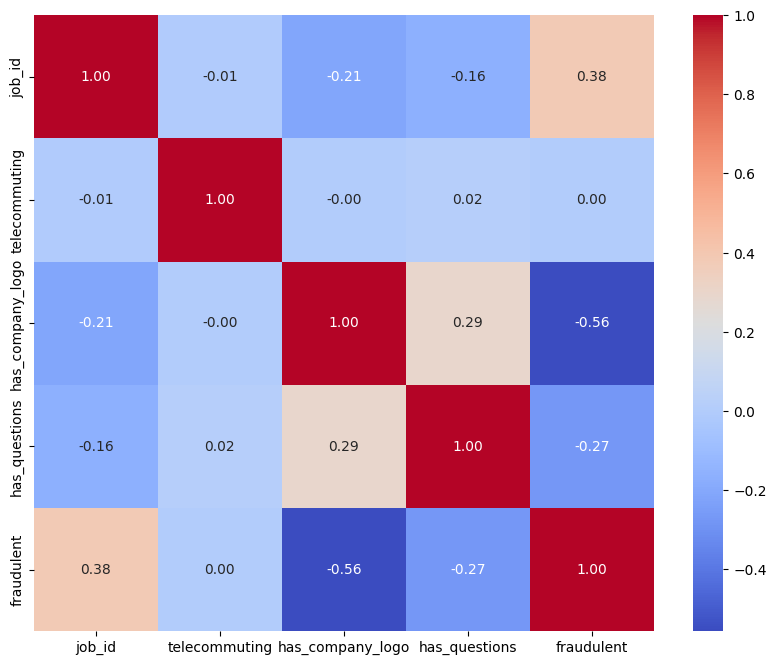

In [ ]:
#correlation heatmap
corr = df_fake_job_pos.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

### Text Distribution for Company Profile, Description, Requirements, Benifits

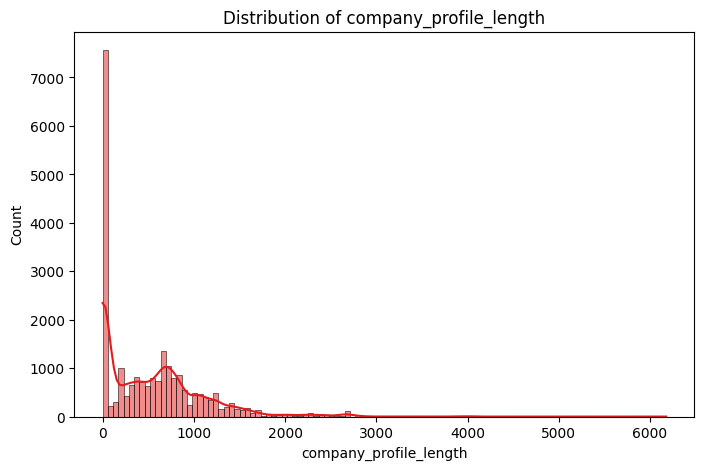

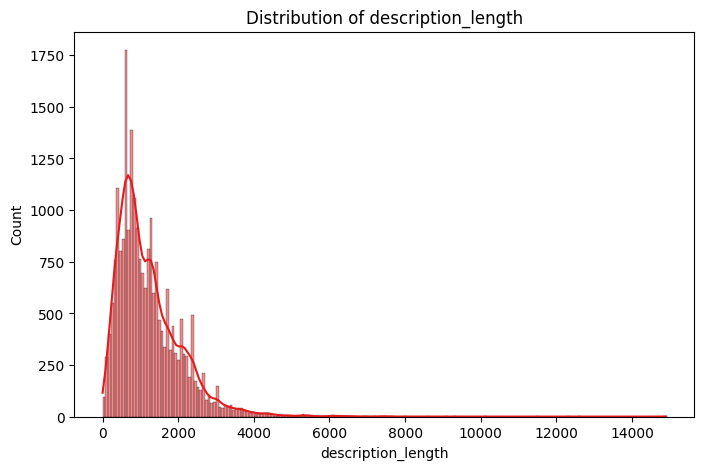

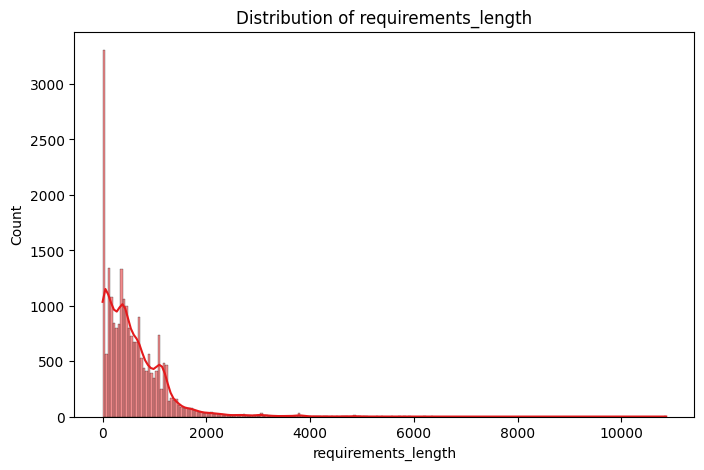

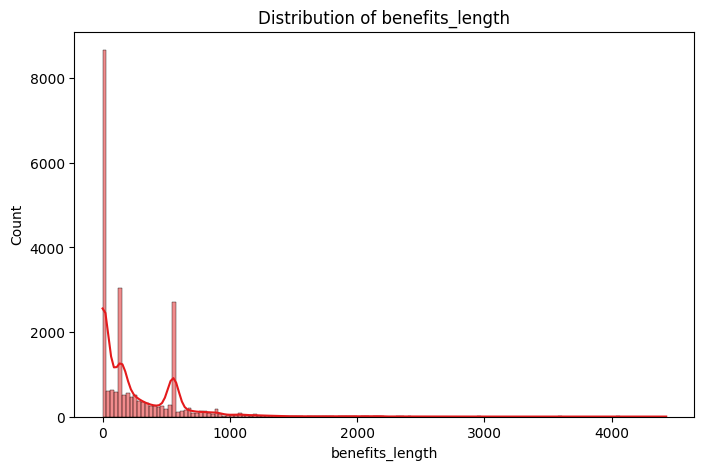

In [ ]:
#exploring Text Length
text_columns = df_fake_job_pos [ ['company_profile', 'description', 'requirements', 'benefits']]

for column in text_columns:
    #lambda function for NaN value handling
    df_fake_job_pos[f'{column}_length'] = df_fake_job_pos[column].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

for column in [f'{column}_length' for column in text_columns]:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_fake_job_pos[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

In [ ]:
#Dropping Newly created columns from the above chart
df_fake_job_pos.drop(columns = ['company_profile_length','description_length','requirements_length','benefits_length'],inplace = True)

## Pre-Processing

### Data Cleaning

#### Replacing NULL values

In [ ]:
#fake job data
df_fake_job_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22880 entries, 0 to 22879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               22880 non-null  int64 
 1   title                22880 non-null  object
 2   location             21805 non-null  object
 3   department           8102 non-null   object
 4   salary_range         4501 non-null   object
 5   company_profile      16093 non-null  object
 6   description          22879 non-null  object
 7   requirements         20180 non-null  object
 8   benefits             15670 non-null  object
 9   telecommuting        22880 non-null  int64 
 10  has_company_logo     22880 non-null  int64 
 11  has_questions        22880 non-null  int64 
 12  employment_type      18321 non-null  object
 13  required_experience  13463 non-null  object
 14  required_education   12594 non-null  object
 15  industry             17027 non-null  object
 16  func

In [ ]:
#replacing NULL/Not specified text with 'UnSpecifed'
not_to_include = ['job_id','telecommuting','has_company_logo','has_questions','salary_range']

for i in df_fake_job_pos.columns:
  if i not in not_to_include:
    df_fake_job_pos[i].fillna(value = 'UnSpecified',inplace = True)
  else:
    df_fake_job_pos[i].fillna(value = np.nan ,inplace = True)

In [ ]:
df_fake_job_pos.head(20)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,0,1,0,Other,Internship,UnSpecified,UnSpecified,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,UnSpecified,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",UnSpecified,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,0,1,0,UnSpecified,UnSpecified,UnSpecified,UnSpecified,UnSpecified,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",UnSpecified,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",UnSpecified,NaN,UnSpecified,Job OverviewApex is an environmental consultin...,UnSpecified,UnSpecified,0,0,0,UnSpecified,UnSpecified,UnSpecified,UnSpecified,UnSpecified,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",UnSpecified,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,UnSpecified,UnSpecified,UnSpecified,UnSpecified,UnSpecified,0
8,9,HP BSM SME,"US, FL, Pensacola",UnSpecified,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,UnSpecified,0,1,1,Full-time,Associate,UnSpecified,Information Technology and Services,UnSpecified,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",UnSpecified,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,UnSpecified,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In columns with words or categories, we used 'Unspecified' to replace missing values. In number columns, we put 'np.nan' to show missing data. Doing this makes it clear and the same for all types of columns.

#### Education

During the process of Exploratory Data Analysis (EDA) for education-related information, we noticed something interesting: there were multiple job postings that required similar education levels, but they were labeled differently.

> For example, some postings might ask for a "Bachelor's Degree," while others might request "Bachelor's or Equivalent."

To tidy up this information and make it easier to understand and analyze, we created a special function. This function helps us to match and group these similar education levels together under a standardized label. So, if two different job postings asked for slightly different labels like "Bachelor's Degree" and "Bachelor's or Equivalent," our function helps us recognize that they're essentially asking for the same educational qualification.
Once we've matched these similar education labels, we save this standardized information into a separate column in our dataset. This way, instead of dealing with various labels for the same education level scattered across the data, we have a consistent column that represents the standardized education levels. This makes it simpler to analyze and draw insights from the educational requirements in the job postings.

Please refer below table for our mapping

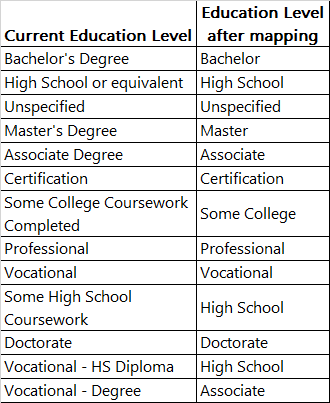

In [ ]:
#checking Null Values and replacing with NaN value.
#df_fake_job_pos['required_education'].fillna(value='NaN',inplace = True)

In [ ]:
#mapping education levels to categories
def map_education_level(education):
    level_map = {
        "Bachelor's Degree": 'Bachelor',
        'High School or equivalent': 'High School',
        'Unspecified': 'Unspecified',
        "Master's Degree": 'Master',
        'Associate Degree': 'Associate',
        'Certification': 'Certification',
        'Some College Coursework Completed': 'Some College',
        'Professional': 'Professional',
        'Vocational': 'Vocational',
        'Some High School Coursework': 'High School',
        'Doctorate': 'Doctorate',
        'Vocational - HS Diploma': 'High School',
        'Vocational - Degree': 'Associate'
    }
    return level_map.get(education, 'Other')

#mapping function applied to create a new column 'education_category'
df_fake_job_pos['mapped_education_level'] = df_fake_job_pos['required_education'].apply(map_education_level)

Mapped Education EDA

Other            10286
Bachelor          6170
High School       3185
Unspecified       1668
Master             604
Associate          347
Certification      265
Some College       144
Professional       114
Vocational          49
Doctorate           48
Name: mapped_education_level, dtype: int64


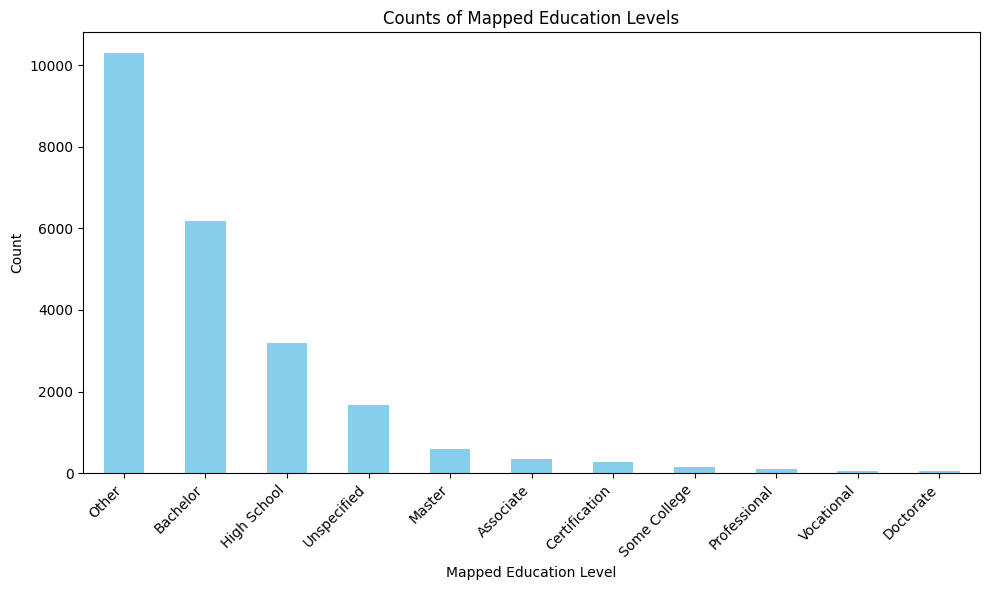

In [ ]:
# value counts for 'required_education' column
education_counts = df_fake_job_pos['mapped_education_level'].value_counts()
print(education_counts)
plt.figure(figsize=(10, 6))
education_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Mapped Education Level')
plt.ylabel('Count')
plt.title('Counts of Mapped Education Levels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Location

In the job postings dataset, the location information wasn't consistently structured or formatted, but we observed that the first two characters consistently represented the country code across all postings. To address this inconsistency, we extracted these initial two characters and established a dedicated column to store them.

This process involved parsing each entry in the location field to isolate the initial two characters, which universally denoted the country code. By storing this information separately, it allowed for a more standardized and streamlined analysis, enabling easier reference and categorization based on country codes rather than dealing with the varied and inconsistent location formats within the original dataset.

In [ ]:
#for country locations
df_fake_job_pos['extracted_country']= df_fake_job_pos['location'].str[:2]
df_fake_job_pos.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,mapped_education_level,extracted_country
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,0,1,0,Other,Internship,UnSpecified,UnSpecified,Marketing,0,Other,US
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,UnSpecified,Marketing and Advertising,Customer Service,0,Other,NZ
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",UnSpecified,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,0,1,0,UnSpecified,UnSpecified,UnSpecified,UnSpecified,UnSpecified,0,Other,US
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Bachelor,US
4,5,Bill Review Manager,"US, FL, Fort Worth",UnSpecified,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Bachelor,US


#### Industry

While exploring the data, we noticed that some job descriptions were listed in different categories that were quite similar. So, we organized them together based on their common traits.
>For instance, in the 'Technology' category for 'Computer Software','Information Technology and Services','Computer Hardware'

By grouping similar types of jobs together, it became easier to understand and compare roles that shared common characteristics in the tech field.

Mapping Table:

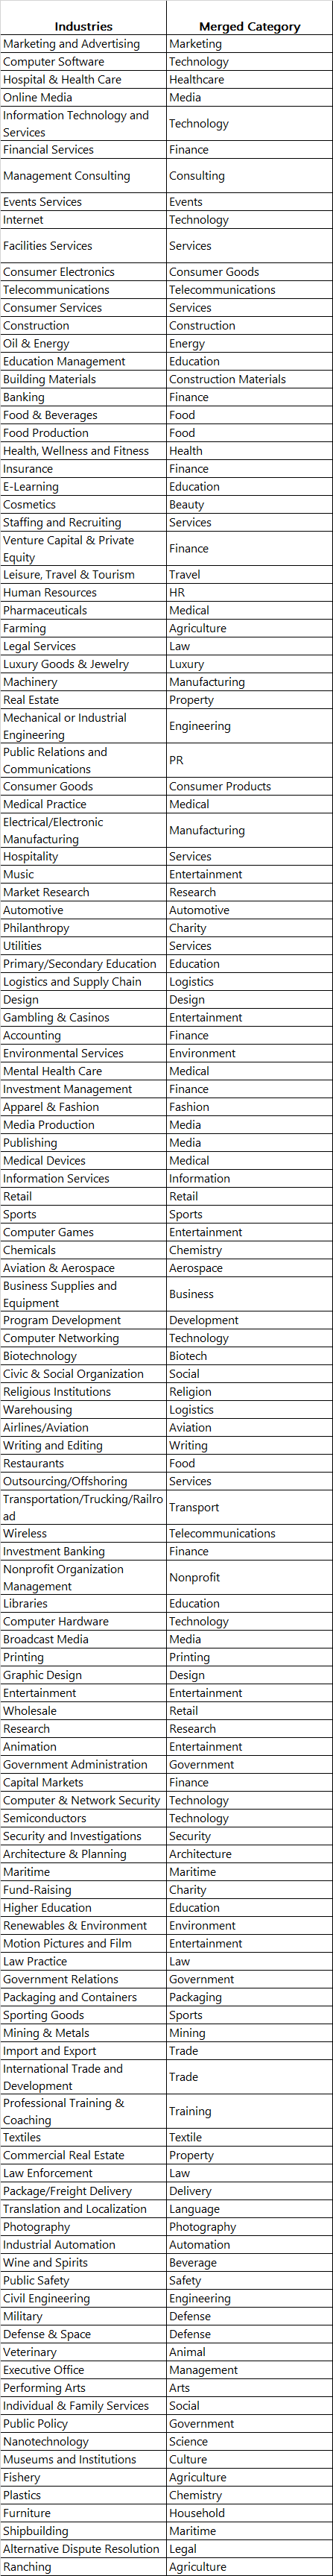

In [ ]:
#mapping industry to categories
def map_industry(industry):
    level_map = {
        #"NaN" : "NaN",
        "Marketing and Advertising":"Marketing",
        "Computer Software":"Technology",
        "Hospital & Health Care":"Healthcare",
        "Online Media":"Media",
        "Information Technology and Services":"Technology",
        "Financial Services":"Finance",
        "Management Consulting":"Consulting",
        "Events Services":"Events",
        "Internet":"Technology",
        "Facilities Services":"Services",
        "Consumer Electronics":"Consumer Goods",
        "Telecommunications":"Telecommunications",
        "Consumer Services":"Services",
        "Construction":"Construction",
        "Oil & Energy":"Energy",
        "Education Management":"Education",
        "Building Materials":"Construction Materials",
        "Banking":"Finance",
        "Food & Beverages":"Food",
        "Food Production":"Food",
        "Health, Wellness and Fitness":"Health",
        "Insurance":"Finance",
        "E-Learning":"Education",
        "Cosmetics":"Beauty",
        "Staffing and Recruiting":"Services",
        "Venture Capital & Private Equity":"Finance",
        "Leisure, Travel & Tourism":"Travel",
        "Human Resources":"HR",
        "Pharmaceuticals":"Medical",
        "Farming":"Agriculture",
        "Legal Services":"Law",
        "Luxury Goods & Jewelry":"Luxury",
        "Machinery":"Manufacturing",
        "Real Estate":"Property",
        "Mechanical or Industrial Engineering":"Engineering",
        "Public Relations and Communications":"PR",
        "Consumer Goods":"Consumer Products",
        "Medical Practice":"Medical",
        "Electrical/Electronic Manufacturing":"Manufacturing",
        "Hospitality":"Services",
        "Music":"Entertainment",
        "Market Research":"Research",
        "Automotive":"Automotive",
        "Philanthropy":"Charity",
        "Utilities":"Services",
        "Primary/Secondary Education":"Education",
        "Logistics and Supply Chain":"Logistics",
        "Design":"Design",
        "Gambling & Casinos":"Entertainment",
        "Accounting":"Finance",
        "Environmental Services":"Environment",
        "Mental Health Care":"Medical",
        "Investment Management":"Finance",
        "Apparel & Fashion":"Fashion",
        "Media Production":"Media",
        "Publishing":"Media",
        "Medical Devices":"Medical",
        "Information Services":"Information",
        "Retail":"Retail",
        "Sports":"Sports",
        "Computer Games":"Entertainment",
        "Chemicals":"Chemistry",
        "Aviation & Aerospace":"Aerospace",
        "Business Supplies and Equipment":"Business",
        "Program Development":"Development",
        "Computer Networking":"Technology",
        "Biotechnology":"Biotech",
        "Civic & Social Organization":"Social",
        "Religious Institutions":"Religion",
        "Warehousing":"Logistics",
        "Airlines/Aviation":"Aviation",
        "Writing and Editing":"Writing",
        "Restaurants":"Food",
        "Outsourcing/Offshoring":"Services",
        "Transportation/Trucking/Railroad":"Transport",
        "Wireless":"Telecommunications",
        "Investment Banking":"Finance",
        "Nonprofit Organization Management":"Nonprofit",
        "Libraries":"Education",
        "Computer Hardware":"Technology",
        "Broadcast Media":"Media",
        "Printing":"Printing",
        "Graphic Design":"Design",
        "Entertainment":"Entertainment",
        "Wholesale":"Retail",
        "Research":"Research",
        "Animation":"Entertainment",
        "Government Administration":"Government",
        "Capital Markets":"Finance",
        "Computer & Network Security":"Technology",
        "Semiconductors":"Technology",
        "Security and Investigations":"Security",
        "Architecture & Planning":"Architecture",
        "Maritime":"Maritime",
        "Fund-Raising":"Charity",
        "Higher Education":"Education",
        "Renewables & Environment":"Environment",
        "Motion Pictures and Film":"Entertainment",
        "Law Practice":"Law",
        "Government Relations":"Government",
        "Packaging and Containers":"Packaging",
        "Sporting Goods":"Sports",
        "Mining & Metals":"Mining",
        "Import and Export":"Trade",
        "International Trade and Development":"Trade",
        "Professional Training & Coaching":"Training",
        "Textiles":"Textile",
        "Commercial Real Estate":"Property",
        "Law Enforcement":"Law",
        "Package/Freight Delivery":"Delivery",
        "Translation and Localization":"Language",
        "Photography":"Photography",
        "Industrial Automation":"Automation",
        "Wine and Spirits":"Beverage",
        "Public Safety":"Safety",
        "Civil Engineering":"Engineering",
        "Military":"Defense",
        "Defense & Space":"Defense",
        "Veterinary":"Animal",
        "Executive Office":"Management",
        "Performing Arts":"Arts",
        "Individual & Family Services":"Social",
        "Public Policy":"Government",
        "Nanotechnology":"Science",
        "Museums and Institutions":"Culture",
        "Fishery":"Agriculture",
        "Plastics":"Chemistry",
        "Furniture":"Household",
        "Shipbuilding":"Maritime",
        "Alternative Dispute Resolution":"Legal",
        "Ranching":"Agriculture"
    }
    return level_map.get(industry, 'Other')

# mapping function applied to a new column 'education_category'
df_fake_job_pos['mapped_industry'] = df_fake_job_pos['industry'].apply(map_industry)

Mapped Industry EDA

<ipython-input-130-a910d69cbcf6>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_counts_combined = top_10.append(pd.Series(other_count, index=['Others']))


([<matplotlib.patches.Wedge at 0x7c932b2e9030>,
 [Text(-1.0938807526426035, -0.11586586640616595, 'UnSpecified'),
  Text(-0.42644965416215963, -1.013972727673173, 'Information Technology and Services'),
  Text(0.06529400437333814, -1.098060423197601, 'Computer Software'),
  Text(0.46375429926972117, -0.997462756151251, 'Oil & Energy'),
  Text(0.767773850300713, -0.7877330225364545, 'Marketing and Advertising'),
  Text(0.9670029566436659, -0.5243141060875709, 'Internet'),
  Text(1.0722133296964524, -0.24567982339062164, 'Financial Services'),
  Text(1.0999013158105326, 0.014734160249536526, 'Education Management'),
  Text(1.0709130305538388, 0.25128724796533747, 'Hospital & Health Care'),
  Text(1.003612614382202, 0.450290706380802, 'Accounting'),
  Text(0.10397696662517639, 1.0950747875882392, 'Others')],
 [Text(-0.5966622287141473, -0.06319956349427233, '25.6%'),
  Text(-0.23260890227026887, -0.5530760332762761, '8.4%'),
  Text(0.03561491147636626, -0.5989420490168732, '6.2%'),
  Text

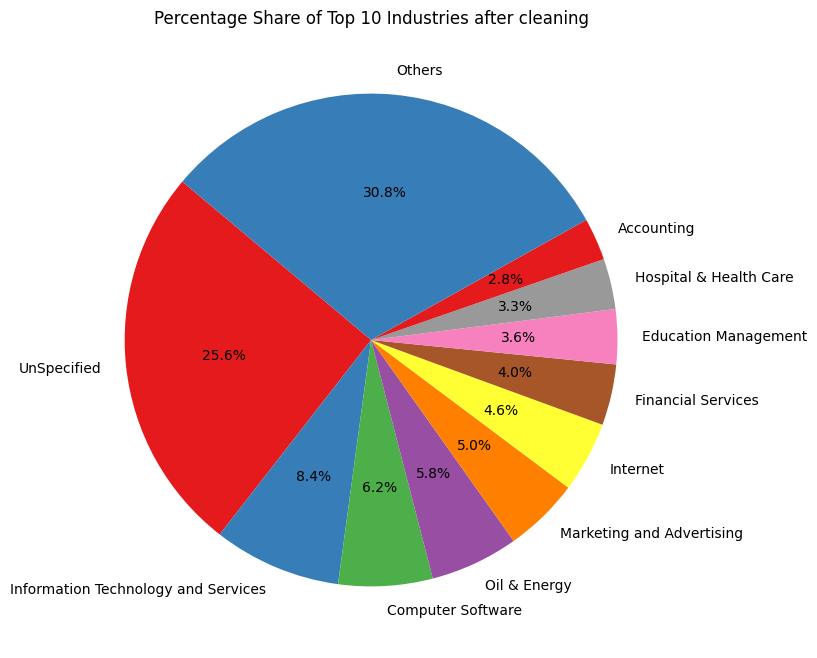

In [ ]:
#value counts for the 'industry' column
industry_counts = df_fake_job_pos['industry'].value_counts()

#top 10 industries and aggregate the rest as 'Others'
top_10 = industry_counts.nlargest(10)
other_count = industry_counts[~industry_counts.index.isin(top_10.index)].sum()
industry_counts_combined = top_10.append(pd.Series(other_count, index=['Others']))
percentage_share = industry_counts_combined / industry_counts_combined.sum() * 100

#Plotting
plt.figure(figsize=(10, 8))
sns.set_palette('Set1')
plt.title('Percentage Share of Top 10 Industries after cleaning')
plt.pie(percentage_share, labels=percentage_share.index, autopct='%1.1f%%', startangle=140)

#### Salary Range

In [ ]:
#splitting salary
salary_df = df_fake_job_pos['salary_range'].str.split(pat='-', n=-1, expand=True)
salary_df[0].unique()[90:101]

month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
salary_df[0] = [month_mapping.get(month, month) for month in salary_df[0]]
salary_df[1] = [month_mapping.get(month, month) for month in salary_df[1]]

salary_df[0].unique()[90:101]

salary_df = salary_df.fillna(value=-1)
salary_df = salary_df.astype('int64')

df_fake_job_pos['minimum_salary'], df_fake_job_pos['maximum_salary'] = salary_df[0].values, salary_df[1].values

df_fake_job_pos[['minimum_salary', 'maximum_salary']] = df_fake_job_pos[['minimum_salary', 'maximum_salary']].replace(-1, 0)
df_fake_job_pos[['minimum_salary', 'maximum_salary']] = df_fake_job_pos[['minimum_salary', 'maximum_salary']].astype('Int64')

In [ ]:
#first three rows where both salary_low and salary_high are not null
df_fake_job_pos.loc[df_fake_job_pos['minimum_salary'].notnull() & df_fake_job_pos['maximum_salary'].notnull()][:3]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_experience,required_education,industry,function,fraudulent,mapped_education_level,extracted_country,mapped_industry,minimum_salary,maximum_salary
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,0,...,Internship,UnSpecified,UnSpecified,Marketing,0,Other,US,Other,0,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,Not Applicable,UnSpecified,Marketing and Advertising,Customer Service,0,Other,NZ,Marketing,0,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",UnSpecified,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,0,...,UnSpecified,UnSpecified,UnSpecified,UnSpecified,0,Other,US,Other,0,0


The code splits the 'salary_range' column into minimum and maximum salary values, converts month abbreviations to numerical representations, handles missing values, and ensures the columns are of integer type. The resulting 'minimum_salary' and 'maximum_salary' columns are then cleaned, replacing missing values with 0 and converting them to nullable integer type.

#### Mapping Numberic values to Text

In [ ]:
#for job_id,telecommuting,has_company_logo,has_questions

#replacing 0 / 'is_absent' and 1 / 'is_present' in the specified column
def replace_values(df, column_name,new_col):
    df[new_col] = df[column_name].replace({0: 'absent', 1: 'present'})
    return df

def replace_values_wfh(df, column_name,new_col):
    df[new_col] = df[column_name].replace({0: 'prohibited', 1: 'allowed'})
    return df

In [ ]:
for i in range(len(df_fake_job_pos)):
  replace_values(df_fake_job_pos,'has_company_logo','has_company_logo_text')
  replace_values(df_fake_job_pos,'has_questions','has_questions_text')
  replace_values_wfh(df_fake_job_pos,'telecommuting','telecommuting_text')

#### Mergeing all the fields into single column

In [ ]:
df_fake_job_pos_updated = df_fake_job_pos[['job_id',
'title',
'extracted_country',
'department',
'minimum_salary',
'maximum_salary',
'company_profile',
'description',
'requirements',
'benefits',
'has_company_logo_text',
'has_questions_text',
'telecommuting_text',
'employment_type',
'required_experience',
'mapped_education_level',
'mapped_industry',
'function',
'fraudulent']].copy()

In [ ]:
df_fake_job_pos_updated

,job_id,title,extracted_country,department,minimum_salary,maximum_salary,company_profile,description,requirements,benefits,has_company_logo_text,has_questions_text,telecommuting_text,employment_type,required_experience,mapped_education_level,mapped_industry,function,fraudulent
0,1,Marketing Intern,US,Marketing,0,0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,present,absent,prohibited,Other,Internship,Other,Other,Marketing,0
1,2,Customer Service - Cloud Video Production,NZ,Success,0,0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,present,absent,prohibited,Full-time,Not Applicable,Other,Marketing,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),US,UnSpecified,0,0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,present,absent,prohibited,UnSpecified,UnSpecified,Other,Other,UnSpecified,0
3,4,Account Executive - Washington DC,US,Sales,0,0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,present,absent,prohibited,Full-time,Mid-Senior level,Bachelor,Technology,Sales,0
4,5,Bill Review Manager,US,UnSpecified,0,0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,present,present,prohibited,Full-time,Mid-Senior level,Bachelor,Healthcare,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,3472,Licensed Practical Nurse,US,UnSpecified,0,0,Aker Solutions is a global provider of product...,Supervises assigned clerical employees and pro...,REQUIREMENTSBasic Qualifications:Proven experi...,Benefits: On board en suite accommodation and ...,absent,absent,prohibited,UnSpecified,Mid-Senior level,High School,Safety,Administrative,1
22876,17832,Receptionist and Office Assistant,US,UnSpecified,0,0,UnSpecified,Account ManagerJoin a growing team that combin...,"Experience in maintenance, creating reports, a...",Benefits: On board en suite accommodation and ...,absent,absent,prohibited,Full-time,Entry level,Bachelor,Energy,Strategy/Planning,1
22877,9377,Senior Software Engineer QA Automation,Un,Clerical,0,0,UnSpecified,Position: Big Data EngineerLocation: San Fran...,Minimum Requirements: Bachelor's Degree in Civ...,All you need is access to the Internet and you...,absent,present,prohibited,Full-time,UnSpecified,Master,Marketing,UnSpecified,1
22878,16804,Executive Chef,US,UnSpecified,0,0,UnSpecified,"Position SummaryThe Asset Manager will plan, d...",Skills and Requirements:BS/BA or equivalent fr...,All you need is access to the Internet and you...,absent,absent,prohibited,Full-time,UnSpecified,High School,Biotech,Engineering,1


In [ ]:
def merge_columns_except_some(df, exclude_columns):
    columns_to_merge = [col for col in df.columns if col not in exclude_columns]
    df['full_text'] = df[columns_to_merge].apply(lambda row: ', '.join([f"{str(row[col])}" for col in columns_to_merge]), axis=1)

    return df

In [ ]:
excluded_cols = ['job_id','fraudulent']
merge_columns_except_some(df_fake_job_pos_updated,excluded_cols)

,job_id,title,extracted_country,department,minimum_salary,maximum_salary,company_profile,description,requirements,benefits,has_company_logo_text,has_questions_text,telecommuting_text,employment_type,required_experience,mapped_education_level,mapped_industry,function,fraudulent,full_text
0,1,Marketing Intern,US,Marketing,0,0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,present,absent,prohibited,Other,Internship,Other,Other,Marketing,0,"Marketing Intern, US, Marketing, 0, 0, We're F..."
1,2,Customer Service - Cloud Video Production,NZ,Success,0,0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,present,absent,prohibited,Full-time,Not Applicable,Other,Marketing,Customer Service,0,"Customer Service - Cloud Video Production, NZ,..."
2,3,Commissioning Machinery Assistant (CMA),US,UnSpecified,0,0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,present,absent,prohibited,UnSpecified,UnSpecified,Other,Other,UnSpecified,0,"Commissioning Machinery Assistant (CMA), US, U..."
3,4,Account Executive - Washington DC,US,Sales,0,0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,present,absent,prohibited,Full-time,Mid-Senior level,Bachelor,Technology,Sales,0,"Account Executive - Washington DC, US, Sales, ..."
4,5,Bill Review Manager,US,UnSpecified,0,0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,present,present,prohibited,Full-time,Mid-Senior level,Bachelor,Healthcare,Health Care Provider,0,"Bill Review Manager, US, UnSpecified, 0, 0, Sp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,3472,Licensed Practical Nurse,US,UnSpecified,0,0,Aker Solutions is a global provider of product...,Supervises assigned clerical employees and pro...,REQUIREMENTSBasic Qualifications:Proven experi...,Benefits: On board en suite accommodation and ...,absent,absent,prohibited,UnSpecified,Mid-Senior level,High School,Safety,Administrative,1,"Licensed Practical Nurse, US, UnSpecified, 0, ..."
22876,17832,Receptionist and Office Assistant,US,UnSpecified,0,0,UnSpecified,Account ManagerJoin a growing team that combin...,"Experience in maintenance, creating reports, a...",Benefits: On board en suite accommodation and ...,absent,absent,prohibited,Full-time,Entry level,Bachelor,Energy,Strategy/Planning,1,"Receptionist and Office Assistant, US, UnSpeci..."
22877,9377,Senior Software Engineer QA Automation,Un,Clerical,0,0,UnSpecified,Position: Big Data EngineerLocation: San Fran...,Minimum Requirements: Bachelor's Degree in Civ...,All you need is access to the Internet and you...,absent,present,prohibited,Full-time,UnSpecified,Master,Marketing,UnSpecified,1,"Senior Software Engineer QA Automation, Un, Cl..."
22878,16804,Executive Chef,US,UnSpecified,0,0,UnSpecified,"Position SummaryThe Asset Manager will plan, d...",Skills and Requirements:BS/BA or equivalent fr...,All you need is access to the Internet and you...,absent,absent,prohibited,Full-time,UnSpecified,High School,Biotech,Engineering,1,"Executive Chef, US, UnSpecified, 0, 0, UnSpeci..."


In [ ]:
df_fake_job_pos_updated['full_text'][0]

"Marketing Intern, US, Marketing, 0, 0, We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City., Food52, a fast-growing, James Beard Award-winning online food community a

In [ ]:
df_fake_job_pos_updated

,job_id,title,extracted_country,department,minimum_salary,maximum_salary,company_profile,description,requirements,benefits,has_company_logo_text,has_questions_text,telecommuting_text,employment_type,required_experience,mapped_education_level,mapped_industry,function,fraudulent,full_text
0,1,Marketing Intern,US,Marketing,0,0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,present,absent,prohibited,Other,Internship,Other,Other,Marketing,0,"Marketing Intern, US, Marketing, 0, 0, We're F..."
1,2,Customer Service - Cloud Video Production,NZ,Success,0,0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,present,absent,prohibited,Full-time,Not Applicable,Other,Marketing,Customer Service,0,"Customer Service - Cloud Video Production, NZ,..."
2,3,Commissioning Machinery Assistant (CMA),US,UnSpecified,0,0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,present,absent,prohibited,UnSpecified,UnSpecified,Other,Other,UnSpecified,0,"Commissioning Machinery Assistant (CMA), US, U..."
3,4,Account Executive - Washington DC,US,Sales,0,0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,present,absent,prohibited,Full-time,Mid-Senior level,Bachelor,Technology,Sales,0,"Account Executive - Washington DC, US, Sales, ..."
4,5,Bill Review Manager,US,UnSpecified,0,0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,present,present,prohibited,Full-time,Mid-Senior level,Bachelor,Healthcare,Health Care Provider,0,"Bill Review Manager, US, UnSpecified, 0, 0, Sp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,3472,Licensed Practical Nurse,US,UnSpecified,0,0,Aker Solutions is a global provider of product...,Supervises assigned clerical employees and pro...,REQUIREMENTSBasic Qualifications:Proven experi...,Benefits: On board en suite accommodation and ...,absent,absent,prohibited,UnSpecified,Mid-Senior level,High School,Safety,Administrative,1,"Licensed Practical Nurse, US, UnSpecified, 0, ..."
22876,17832,Receptionist and Office Assistant,US,UnSpecified,0,0,UnSpecified,Account ManagerJoin a growing team that combin...,"Experience in maintenance, creating reports, a...",Benefits: On board en suite accommodation and ...,absent,absent,prohibited,Full-time,Entry level,Bachelor,Energy,Strategy/Planning,1,"Receptionist and Office Assistant, US, UnSpeci..."
22877,9377,Senior Software Engineer QA Automation,Un,Clerical,0,0,UnSpecified,Position: Big Data EngineerLocation: San Fran...,Minimum Requirements: Bachelor's Degree in Civ...,All you need is access to the Internet and you...,absent,present,prohibited,Full-time,UnSpecified,Master,Marketing,UnSpecified,1,"Senior Software Engineer QA Automation, Un, Cl..."
22878,16804,Executive Chef,US,UnSpecified,0,0,UnSpecified,"Position SummaryThe Asset Manager will plan, d...",Skills and Requirements:BS/BA or equivalent fr...,All you need is access to the Internet and you...,absent,absent,prohibited,Full-time,UnSpecified,High School,Biotech,Engineering,1,"Executive Chef, US, UnSpecified, 0, 0, UnSpeci..."


### Preprocessing NLP steps

In [ ]:
#word tokenization
def description_tokenize(description):
  return nltk.word_tokenize(description)
#removing lowercase
def description_lower(description):
  return description.lower()
#removing non-characters
def description_alpha(tokens):
  return [w for w in tokens if w.isalpha()]
#removing stop words
def description_stopwords(alphatokens):
  nltk_stops_words = nltk.corpus.stopwords.words('english')
  return [word for word in alphatokens if word not in nltk_stops_words]
#lemmatization
def description_lemmatize(revised_tokens):
  wnl = nltk.WordNetLemmatizer()
  return [wnl.lemmatize(tokens) for tokens in revised_tokens]
#pos tagging
def pos_tag(tokens):
  return nltk.pos_tag(tokens)
def detokenization(tokens):
  return ' '.join(tokens)

#### Tokenization

In [ ]:
#Tokenizing the data specifically for bigrams.
df_fake_job_pos_updated['full_tokens_uncleaned_ngrams'] = df_fake_job_pos_updated['full_text'].apply(description_tokenize)
df_fake_job_pos_updated['full_uncleaned_text'] = df_fake_job_pos_updated['full_tokens_uncleaned_ngrams'].apply(detokenization)

#### Bigrams & Trigrams before cleaning text

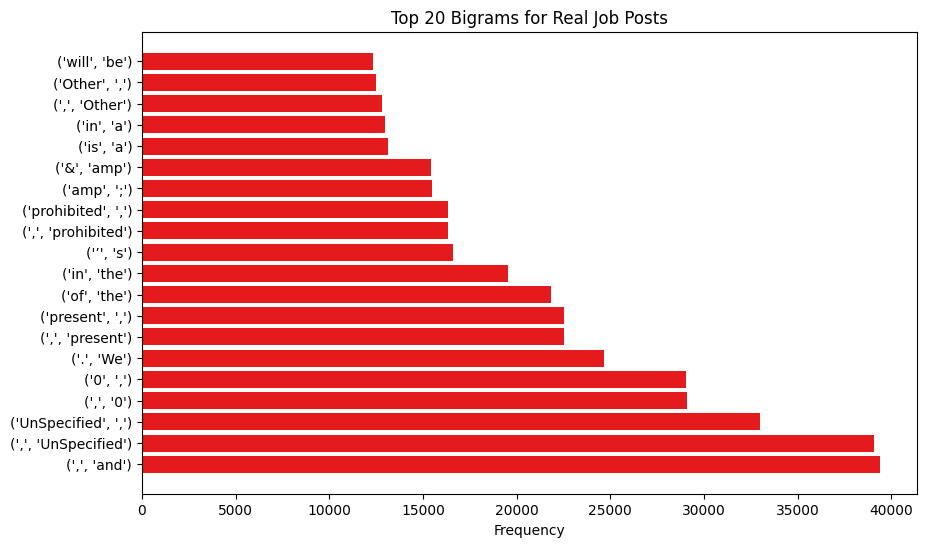

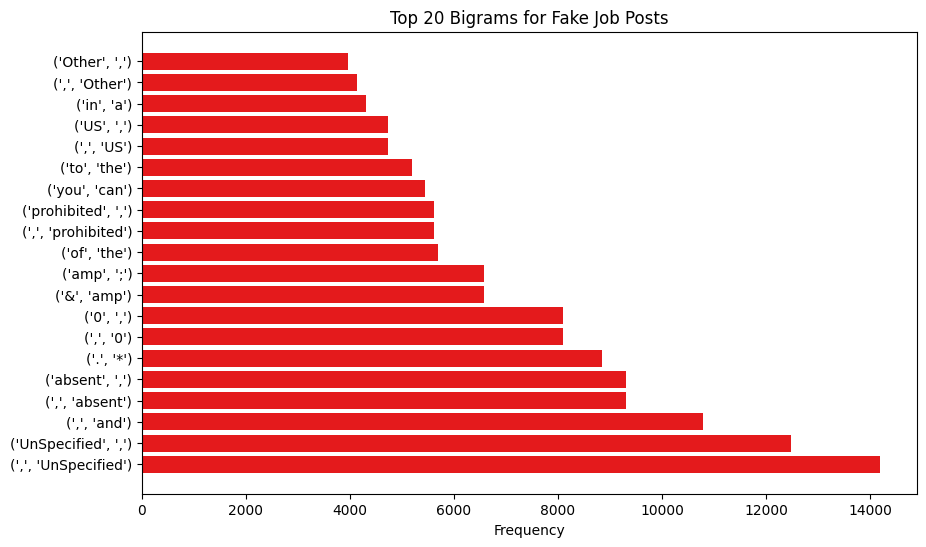

In [ ]:
# Function to get top 20 bigrams
def get_top_bigrams(data):
    bigrams_list = list(bigrams(data))
    bigrams_count = Counter(bigrams_list)
    return dict(bigrams_count.most_common(20))

# Get top bigrams for real job posts
real_bigrams = get_top_bigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 0]['full_tokens_uncleaned_ngrams'].explode())

# Get top bigrams for fake job posts
fake_bigrams = get_top_bigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 1]['full_tokens_uncleaned_ngrams'].explode())

# Create bar graphs
def plot_bigrams(bigrams, title):
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(bigrams)), list(bigrams.values()), align='center')
    plt.yticks(range(len(bigrams)), list(bigrams.keys()))
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()

# Plot top bigrams for real job posts
plot_bigrams(real_bigrams, 'Top 20 Bigrams for Real Job Posts')

# Plot top bigrams for fake job posts
plot_bigrams(fake_bigrams, 'Top 20 Bigrams for Fake Job Posts')

In [ ]:
# Function to get top 20 trigrams
def get_top_trigrams(data):
    trigrams_list = list(ngrams(data, 3))
    trigrams_count = Counter(trigrams_list)
    return trigrams_count.most_common(20)

# Get top trigrams for real job posts
real_trigrams = get_top_trigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 0]['full_tokens_uncleaned_ngrams'].explode())

# Get top trigrams for fake job posts
fake_trigrams = get_top_trigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 1]['full_tokens_uncleaned_ngrams'].explode())

# Print the results
print("Top 20 Trigrams for Real Job Posts:")
print(real_trigrams)

print("\nTop 20 Trigrams for Fake Job Posts:")
print(fake_trigrams)


Top 20 Trigrams for Real Job Posts:
[((',', 'UnSpecified', ','), 32969), ((',', '0', ','), 29067), ((',', 'present', ','), 22492), ((',', 'prohibited', ','), 16311), (('&', 'amp', ';'), 15454), (('0', ',', '0'), 14507), ((',', 'Other', ','), 12495), ((',', 'absent', ','), 11549), ((',', 'Full-time', ','), 11140), (('prohibited', ',', 'Full-time'), 10716), ((',', 'US', ','), 9945), (('UnSpecified', ',', '0'), 9667), (('absent', ',', 'prohibited'), 8171), (('present', ',', 'prohibited'), 8140), (('present', ',', 'present'), 7679), (('US', ',', 'UnSpecified'), 7193), (('present', ',', 'absent'), 6258), (('.', 'We', 'are'), 5858), (('UnSpecified', ',', 'Other'), 5386), (('UnSpecified', ',', 'UnSpecified'), 5300)]

Top 20 Trigrams for Fake Job Posts:
[((',', 'UnSpecified', ','), 12483), ((',', 'absent', ','), 9315), ((',', '0', ','), 8091), (('&', 'amp', ';'), 6579), ((',', 'prohibited', ','), 5622), ((',', 'US', ','), 4734), (('absent', ',', 'prohibited'), 4526), (('0', ',', '0'), 4032), (

In [ ]:
#applying to columns
df_fake_job_pos_updated['full_tokens_cleaned'] = df_fake_job_pos_updated['full_text'].apply(description_lower)
df_fake_job_pos_updated['full_tokens_cleaned'] = df_fake_job_pos_updated['full_tokens_cleaned'].apply(description_tokenize)
df_fake_job_pos_updated['full_tokens_cleaned'] = df_fake_job_pos_updated['full_tokens_cleaned'].apply(description_alpha)
df_fake_job_pos_updated['full_tokens_cleaned'] = df_fake_job_pos_updated['full_tokens_cleaned'].apply(description_stopwords)
df_fake_job_pos_updated['full_tokens_cleaned'] = df_fake_job_pos_updated['full_tokens_cleaned'].apply(description_lemmatize)
df_fake_job_pos_updated['full_text_cleaned'] = df_fake_job_pos_updated['full_tokens_cleaned'].apply(detokenization)

In [ ]:
df_fake_job_pos_updated

,job_id,title,extracted_country,department,minimum_salary,maximum_salary,company_profile,description,requirements,benefits,...,required_experience,mapped_education_level,mapped_industry,function,fraudulent,full_text,full_tokens_uncleaned_ngrams,full_uncleaned_text,full_tokens_cleaned,full_text_cleaned
0,1,Marketing Intern,US,Marketing,0,0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,...,Internship,Other,Other,Marketing,0,"Marketing Intern, US, Marketing, 0, 0, We're F...","[Marketing, Intern, ,, US, ,, Marketing, ,, 0,...","Marketing Intern , US , Marketing , 0 , 0 , We...","[marketing, intern, u, marketing, created, gro...",marketing intern u marketing created groundbre...
1,2,Customer Service - Cloud Video Production,NZ,Success,0,0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,...,Not Applicable,Other,Marketing,Customer Service,0,"Customer Service - Cloud Video Production, NZ,...","[Customer, Service, -, Cloud, Video, Productio...","Customer Service - Cloud Video Production , NZ...","[customer, service, cloud, video, production, ...",customer service cloud video production nz suc...
2,3,Commissioning Machinery Assistant (CMA),US,UnSpecified,0,0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,...,UnSpecified,Other,Other,UnSpecified,0,"Commissioning Machinery Assistant (CMA), US, U...","[Commissioning, Machinery, Assistant, (, CMA, ...","Commissioning Machinery Assistant ( CMA ) , US...","[commissioning, machinery, assistant, cma, u, ...",commissioning machinery assistant cma u unspec...
3,4,Account Executive - Washington DC,US,Sales,0,0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,...,Mid-Senior level,Bachelor,Technology,Sales,0,"Account Executive - Washington DC, US, Sales, ...","[Account, Executive, -, Washington, DC, ,, US,...","Account Executive - Washington DC , US , Sales...","[account, executive, washington, dc, u, sale, ...",account executive washington dc u sale passion...
4,5,Bill Review Manager,US,UnSpecified,0,0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,...,Mid-Senior level,Bachelor,Healthcare,Health Care Provider,0,"Bill Review Manager, US, UnSpecified, 0, 0, Sp...","[Bill, Review, Manager, ,, US, ,, UnSpecified,...","Bill Review Manager , US , UnSpecified , 0 , 0...","[bill, review, manager, u, unspecified, spotso...",bill review manager u unspecified spotsource s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,3472,Licensed Practical Nurse,US,UnSpecified,0,0,Aker Solutions is a global provider of product...,Supervises assigned clerical employees and pro...,REQUIREMENTSBasic Qualifications:Proven experi...,Benefits: On board en suite accommodation and ...,...,Mid-Senior level,High School,Safety,Administrative,1,"Licensed Practical Nurse, US, UnSpecified, 0, ...","[Licensed, Practical, Nurse, ,, US, ,, UnSpeci...","Licensed Practical Nurse , US , UnSpecified , ...","[licensed, practical, nurse, u, unspecified, a...",licensed practical nurse u unspecified aker so...
22876,17832,Receptionist and Office Assistant,US,UnSpecified,0,0,UnSpecified,Account ManagerJoin a growing team that combin...,"Experience in maintenance, creating reports, a...",Benefits: On board en suite accommodation and ...,...,Entry level,Bachelor,Energy,Strategy/Planning,1,"Receptionist and Office Assistant, US, UnSpeci...","[Rece

#### EDA after NLP Preprocessing

In [ ]:
print(df_fake_job_pos_updated['fraudulent'].value_counts())
#dataframe based on fraudulent status.
real_df = df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 0]
fraudulent_df = df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 1]

0    17014
1     5866
Name: fraudulent, dtype: int64


### WordCloud based uncleaned text

In [ ]:
real_df

,job_id,title,extracted_country,department,minimum_salary,maximum_salary,company_profile,description,requirements,benefits,...,required_experience,mapped_education_level,mapped_industry,function,fraudulent,full_text,full_tokens_uncleaned_ngrams,full_uncleaned_text,full_tokens_cleaned,full_text_cleaned
0,1,Marketing Intern,US,Marketing,0,0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UnSpecified,...,Internship,Other,Other,Marketing,0,"Marketing Intern, US, Marketing, 0, 0, We're F...","[Marketing, Intern, ,, US, ,, Marketing, ,, 0,...","Marketing Intern , US , Marketing , 0 , 0 , We...","[marketing, intern, u, marketing, created, gro...",marketing intern u marketing created groundbre...
1,2,Customer Service - Cloud Video Production,NZ,Success,0,0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,...,Not Applicable,Other,Marketing,Customer Service,0,"Customer Service - Cloud Video Production, NZ,...","[Customer, Service, -, Cloud, Video, Productio...","Customer Service - Cloud Video Production , NZ...","[customer, service, cloud, video, production, ...",customer service cloud video production nz suc...
2,3,Commissioning Machinery Assistant (CMA),US,UnSpecified,0,0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,UnSpecified,...,UnSpecified,Other,Other,UnSpecified,0,"Commissioning Machinery Assistant (CMA), US, U...","[Commissioning, Machinery, Assistant, (, CMA, ...","Commissioning Machinery Assistant ( CMA ) , US...","[commissioning, machinery, assistant, cma, u, ...",commissioning machinery assistant cma u unspec...
3,4,Account Executive - Washington DC,US,Sales,0,0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,...,Mid-Senior level,Bachelor,Technology,Sales,0,"Account Executive - Washington DC, US, Sales, ...","[Account, Executive, -, Washington, DC, ,, US,...","Account Executive - Washington DC , US , Sales...","[account, executive, washington, dc, u, sale, ...",account executive washington dc u sale passion...
4,5,Bill Review Manager,US,UnSpecified,0,0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,...,Mid-Senior level,Bachelor,Healthcare,Health Care Provider,0,"Bill Review Manager, US, UnSpecified, 0, 0, Sp...","[Bill, Review, Manager, ,, US, ,, UnSpecified,...","Bill Review Manager , US , UnSpecified , 0 , 0...","[bill, review, manager, u, unspecified, spotso...",bill review manager u unspecified spotsource s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,CA,Sales,0,0,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,...,Mid-Senior level,Other,Technology,Sales,0,"Account Director - Distribution , CA, Sales, 0...","[Account, Director, -, Distribution, ,, CA, ,,...","Account Director - Distribution , CA , Sales ,...","[account, director, distribution, ca, sale, ve...",account director distribution ca sale vend loo...
17876,17877,Payroll Accountant,US,Accounting,0,0,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,...,Mid-Senior level,Bachelor,Technology,Accounting/Auditing,0,"Payroll Accountant, US, Accounting,

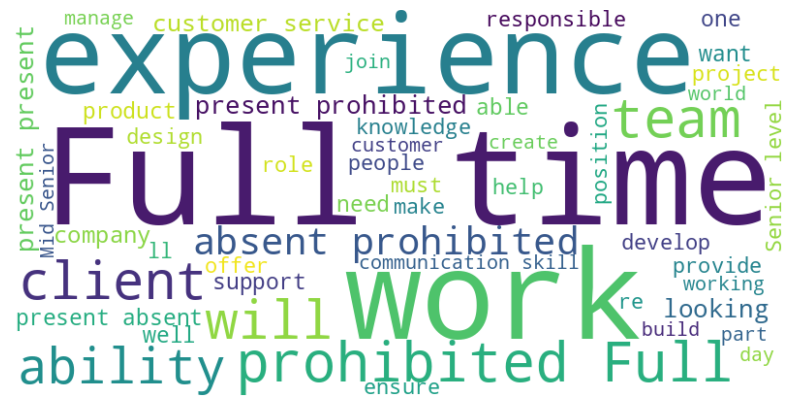

In [ ]:
#word cloud for real_df
text_without_unspecified = ' '.join([word for text in real_df['full_uncleaned_text'] for word in text.split() if word.lower() != 'unspecified'])
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(text_without_unspecified)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

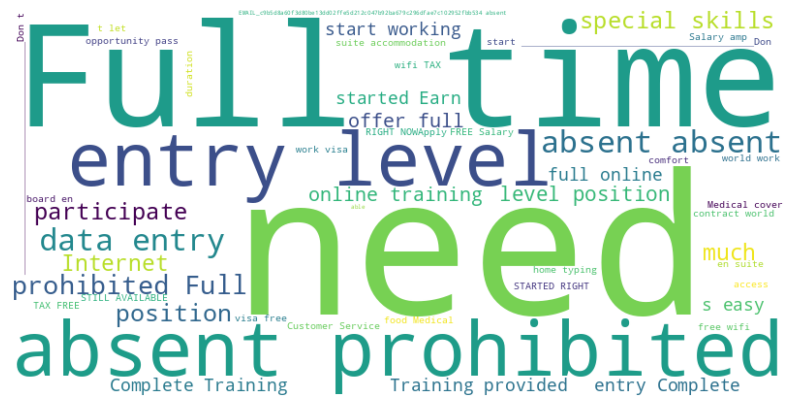

In [ ]:
#word_cloud for fake_df
text_without_unspecified = ' '.join([word for text in fraudulent_df['full_uncleaned_text'] for word in text.split() if word.lower() != 'unspecified'])
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(text_without_unspecified)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

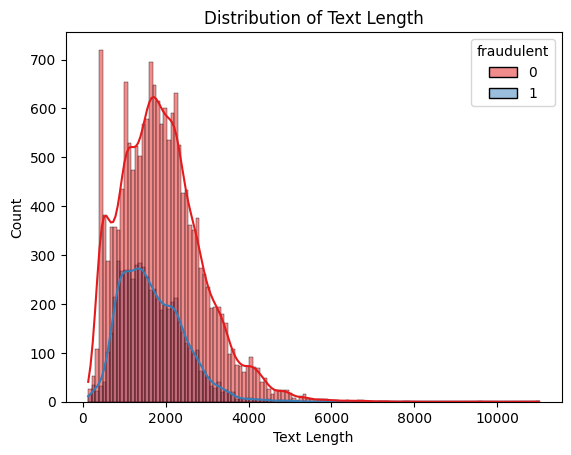

In [ ]:
#plotting text length
df_fake_job_pos_updated['text_length'] = df_fake_job_pos_updated['full_text_cleaned'].apply(len)
sns.histplot(df_fake_job_pos_updated, x='text_length', hue='fraudulent', kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

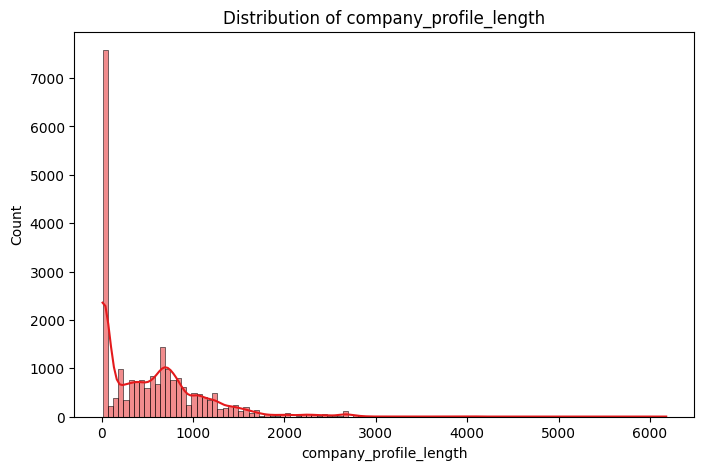

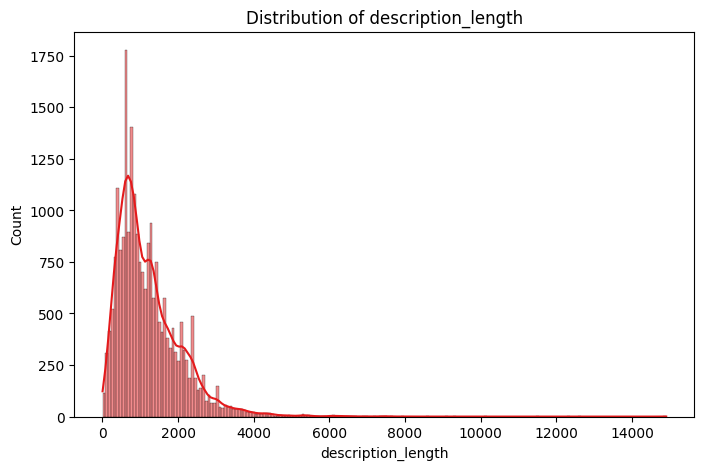

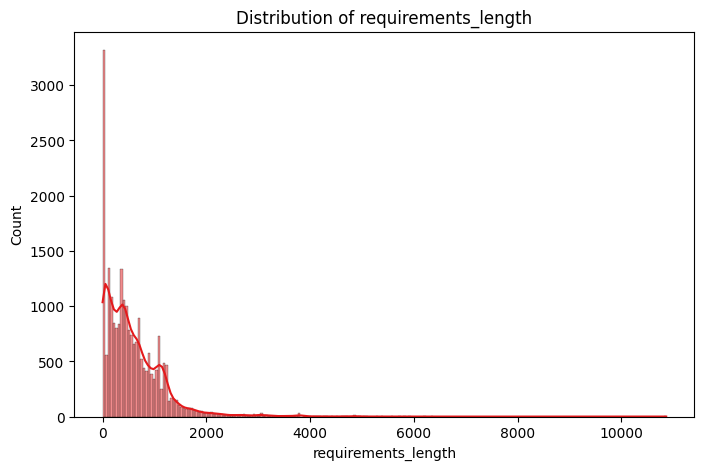

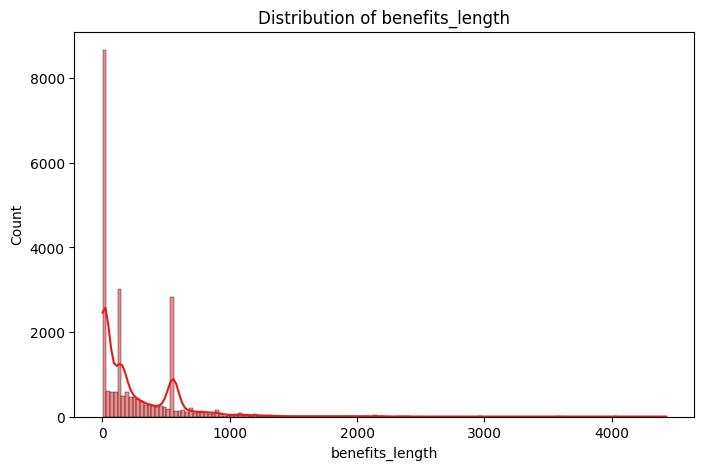

In [ ]:
#plotting job requirements length
text_columns = df_fake_job_pos_updated[ ['company_profile', 'description', 'requirements', 'benefits']]

for column in text_columns:
    #lambda function to handle NaN values
    df_fake_job_pos_updated[f'{column}_length'] = df_fake_job_pos_updated[column].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

for column in [f'{column}_length' for column in text_columns]:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_fake_job_pos_updated[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

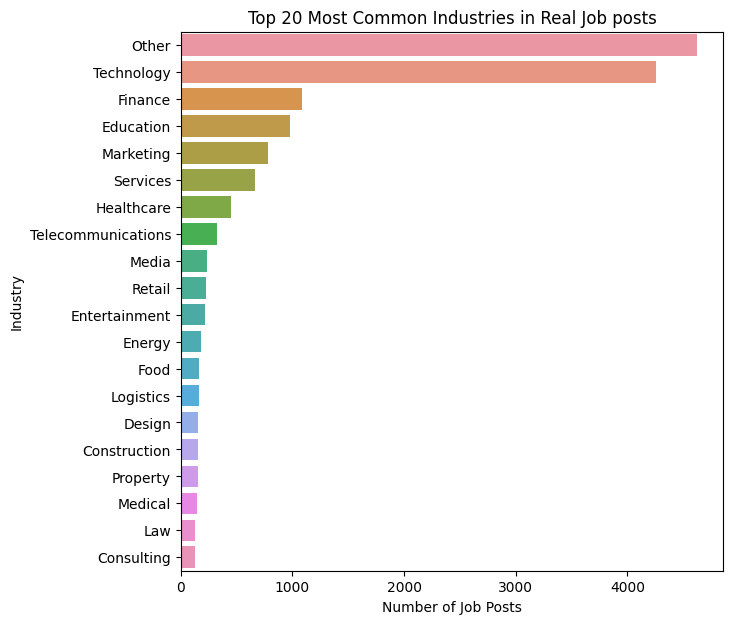

In [ ]:
#plotting top 20 common inustries (real jobs)
industry = list(real_df['mapped_industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Job Posts']
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.barplot(y='Industry', x='Number of Job Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries in Real Job posts")
plt.show()

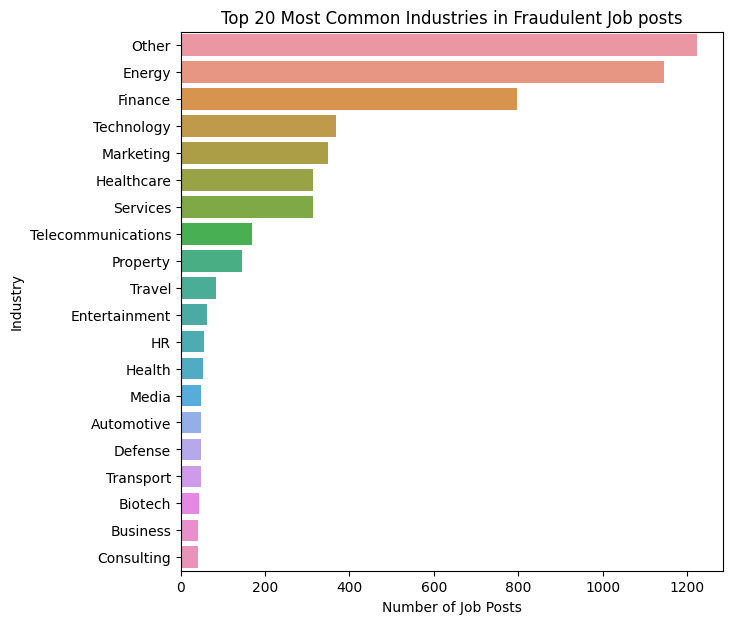

In [ ]:
#plotting top 20 common inustries (fake jobs)
industry = list(fraudulent_df['mapped_industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Job Posts']
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.barplot(y='Industry', x='Number of Job Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries in Fraudulent Job posts")
plt.show()

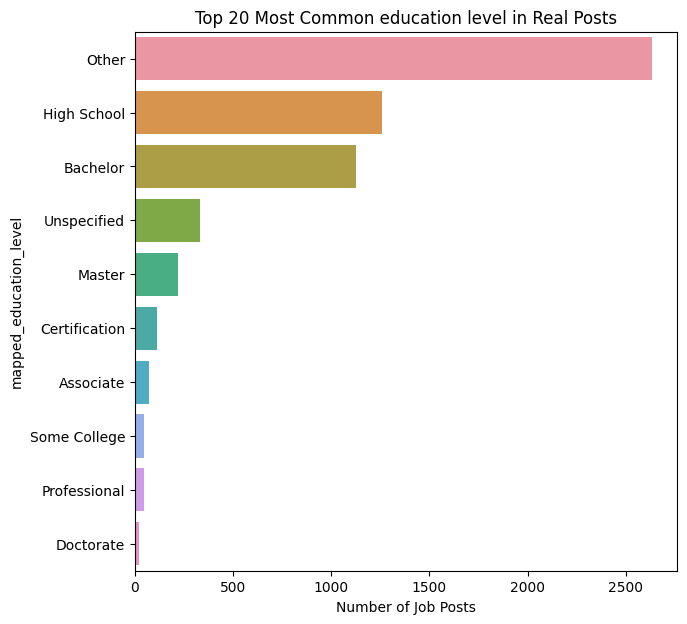

In [ ]:
#plotting top 20 common education (real jobs)
education=list(fraudulent_df['mapped_education_level'])
counts = Counter(education).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['mapped_education_level', 'Number of Job Posts']
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.barplot(y='mapped_education_level', x='Number of Job Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common education level in Real Posts')
plt.show()

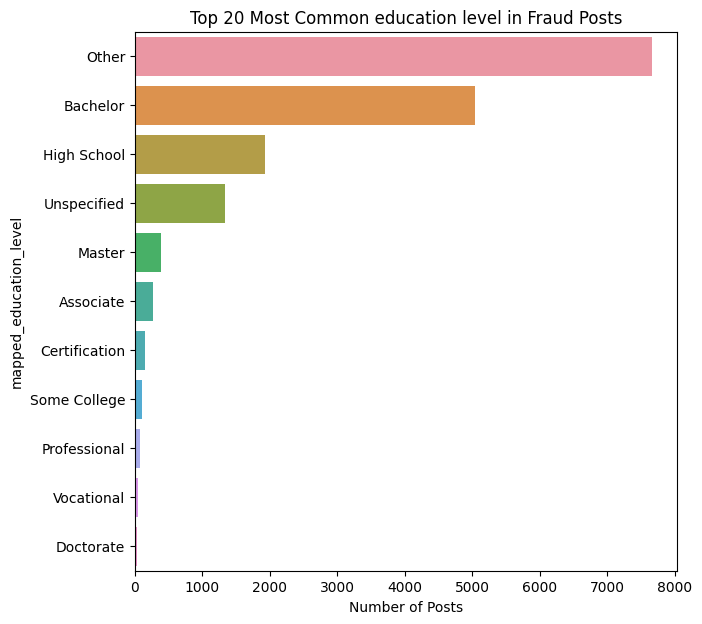

In [ ]:
#plotting top 20 common education (fake jobs)
education=list(real_df['mapped_education_level'])
counts = Counter(education).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['mapped_education_level', 'Number of Posts']
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.barplot(y='mapped_education_level', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common education level in Fraud Posts')
plt.show()

#### Bigrams & Trigrams after cleaning text

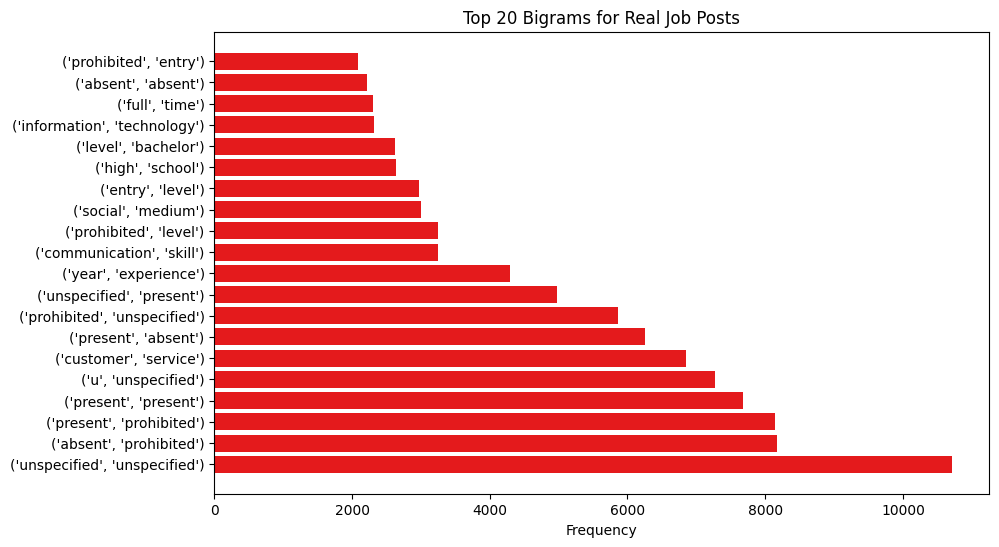

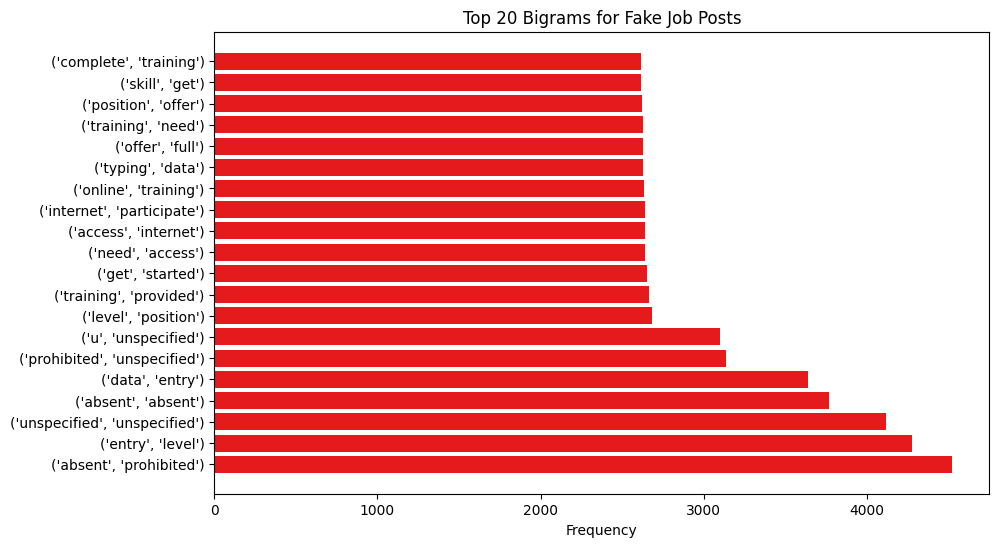

In [ ]:
# Function to get top 20 bigrams
def get_top_bigrams(data):
    bigrams_list = list(bigrams(data))
    bigrams_count = Counter(bigrams_list)
    return dict(bigrams_count.most_common(20))

# Get top bigrams for real job posts
real_bigrams = get_top_bigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 0]['full_tokens_cleaned'].explode())

# Get top bigrams for fake job posts
fake_bigrams = get_top_bigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 1]['full_tokens_cleaned'].explode())

# Create bar graphs
def plot_bigrams(bigrams, title):
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(bigrams)), list(bigrams.values()), align='center')
    plt.yticks(range(len(bigrams)), list(bigrams.keys()))
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()

# Plot top bigrams for real job posts
plot_bigrams(real_bigrams, 'Top 20 Bigrams for Real Job Posts')

# Plot top bigrams for fake job posts
plot_bigrams(fake_bigrams, 'Top 20 Bigrams for Fake Job Posts')

In [ ]:
# Function to get top 20 trigrams
def get_top_trigrams(data):
    trigrams_list = list(ngrams(data, 3))
    trigrams_count = Counter(trigrams_list)
    return trigrams_count.most_common(20)

# Get top trigrams for real job posts
real_trigrams = get_top_trigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 0]['full_tokens_cleaned'].explode())

# Get top trigrams for fake job posts
fake_trigrams = get_top_trigrams(df_fake_job_pos_updated[df_fake_job_pos_updated['fraudulent'] == 1]['full_tokens_cleaned'].explode())

# Print the results
print("Top 20 Trigrams for Real Job Posts:")
print(real_trigrams)

print("\nTop 20 Trigrams for Fake Job Posts:")
print(fake_trigrams)


Top 20 Trigrams for Real Job Posts:
[(('present', 'present', 'prohibited'), 7333), (('present', 'absent', 'prohibited'), 6044), (('prohibited', 'unspecified', 'unspecified'), 3707), (('absent', 'prohibited', 'unspecified'), 3309), (('unspecified', 'present', 'absent'), 3062), (('unspecified', 'unspecified', 'unspecified'), 2623), (('present', 'prohibited', 'unspecified'), 2554), (('absent', 'absent', 'prohibited'), 2127), (('prohibited', 'entry', 'level'), 2092), (('unspecified', 'present', 'present'), 1914), (('prohibited', 'level', 'bachelor'), 1742), (('absent', 'prohibited', 'level'), 1626), (('present', 'prohibited', 'level'), 1621), (('unspecified', 'absent', 'absent'), 1540), (('u', 'unspecified', 'unspecified'), 1302), (('unspecified', 'unspecified', 'present'), 1278), (('absent', 'prohibited', 'entry'), 1260), (('technology', 'information', 'technology'), 1251), (('level', 'high', 'school'), 1226), (('level', 'bachelor', 'technology'), 1209)]

Top 20 Trigrams for Fake Job Post

### WordCloud based cleaned text

In [ ]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17014 entries, 0 to 17879
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   job_id                        17014 non-null  int64 
 1   title                         17014 non-null  object
 2   extracted_country             17014 non-null  object
 3   department                    17014 non-null  object
 4   minimum_salary                17014 non-null  Int64 
 5   maximum_salary                17014 non-null  Int64 
 6   company_profile               17014 non-null  object
 7   description                   17014 non-null  object
 8   requirements                  17014 non-null  object
 9   benefits                      17014 non-null  object
 10  has_company_logo_text         17014 non-null  object
 11  has_questions_text            17014 non-null  object
 12  telecommuting_text            17014 non-null  object
 13  employment_type 

In [ ]:
fraudulent_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5866 entries, 98 to 22879
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   job_id                        5866 non-null   int64 
 1   title                         5866 non-null   object
 2   extracted_country             5866 non-null   object
 3   department                    5866 non-null   object
 4   minimum_salary                5866 non-null   Int64 
 5   maximum_salary                5866 non-null   Int64 
 6   company_profile               5866 non-null   object
 7   description                   5866 non-null   object
 8   requirements                  5866 non-null   object
 9   benefits                      5866 non-null   object
 10  has_company_logo_text         5866 non-null   object
 11  has_questions_text            5866 non-null   object
 12  telecommuting_text            5866 non-null   object
 13  employment_type 

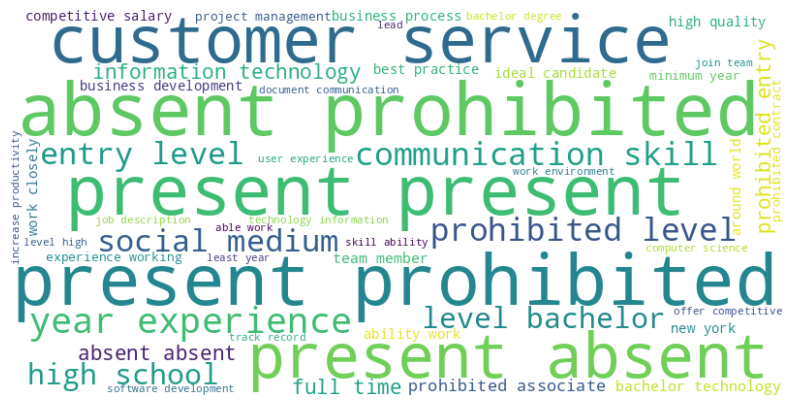

In [ ]:
#word cloud for real_df
text_without_unspecified = ' '.join([word for text in real_df['full_text_cleaned'] for word in text.split() if word.lower() != 'unspecified'])
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(text_without_unspecified)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

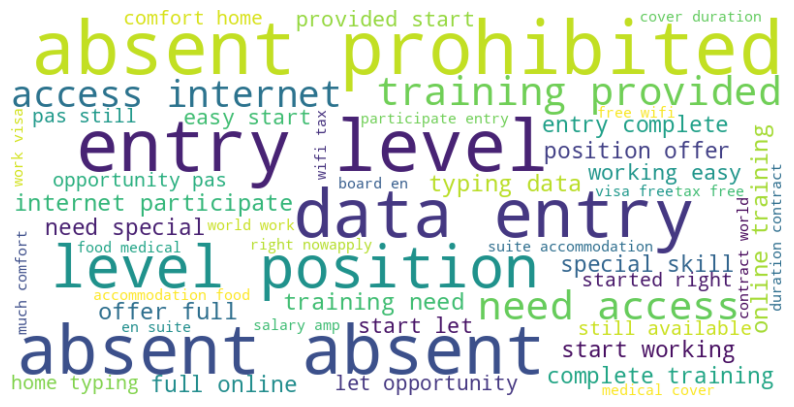

In [ ]:
#word_cloud for fake_df
text_without_unspecified = ' '.join([word for text in fraudulent_df['full_text_cleaned'] for word in text.split() if word.lower() != 'unspecified'])
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(text_without_unspecified)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Splitting Data into Test and Train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_fake_job_pos_updated['full_text_cleaned'], df_fake_job_pos_updated['fraudulent'], test_size=0.4,shuffle=True,random_state = 46)
print(f"Shape of X_train is {X_train.shape} and y_train is {y_train.shape}")
print(f"Shape of X_test is {X_test.shape} and y_train is {y_test.shape}")

X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = train_test_split(df_fake_job_pos_updated['full_tokens_cleaned'], df_fake_job_pos_updated['fraudulent'], test_size=0.4,shuffle=True,random_state = 46)
print(f"Shape of X_train is {X_train.shape} and y_train is {y_train.shape}")
print(f"Shape of X_test is {X_test.shape} and y_train is {y_test.shape}")

Shape of X_train is (13728,) and y_train is (13728,)
Shape of X_test is (9152,) and y_train is (9152,)
Shape of X_train is (13728,) and y_train is (13728,)
Shape of X_test is (9152,) and y_train is (9152,)


### Vectorizing Job Postings

#### TFIDF

In [ ]:
#TFID Matrix for model
def calculate_tfidf_for_training_data(train_data):
    tfidf_vectorizer = TfidfVectorizer(min_df = 0.01, max_df = 0.99,analyzer = 'word')
    tfidf_train_matrix = tfidf_vectorizer.fit_transform(train_data)
    tfidf_train_matrix
    print(tfidf_train_matrix.shape)
    return tfidf_train_matrix, tfidf_vectorizer


In [ ]:
#TFID Matrix for model
def calculate_tfidf_for_testing(test_data,tfidf_vectorizer):
    tfidf_matrix = tfidf_vectorizer.transform(test_data)
    tfidf_matrix
    print(tfidf_matrix.shape)
    return tfidf_matrix


#### Count Vectorization

In [ ]:
#CoutVect Matrix for model
def calculate_cntvect_for_training_data(train_data):
    cnt_vectorizer = CountVectorizer(min_df = 0.01, max_df = 0.99,analyzer = 'word')
    #fit and transform the text data to calculate TFIDF
    cnt_train_matrix = cnt_vectorizer.fit_transform(train_data)
    cnt_train_matrix
    print(cnt_train_matrix.shape)
    return cnt_train_matrix, cnt_vectorizer


In [ ]:
#CountVect Matrix for model(testing)
def calculate_cntvect_for_testing(test_data,cnt_vectorizer):
    cnt_matrix = cnt_vectorizer.transform(test_data)
    cnt_matrix
    print(cnt_matrix.shape)
    return cnt_matrix

#### PCA- Dimension Reduction

In [ ]:
#PCA dimensionality reduction
def reduce_dimension(X_train,X_test,no_of_dimensions):
  pca = TruncatedSVD(n_components=no_of_dimensions)
  x_train_reduced = pca.fit_transform(X_train.toarray())
  x_test_reduced = pca.transform(X_test.toarray())
  return x_train_reduced,x_test_reduced

#### Word2Vec

In [ ]:
#training Word2Vec Model on train_data
def word2vec_train_test(train_data, vector_size=100, window=5, min_count=1, workers=4):
    word2vec_model = gensim.models.Word2Vec(sentences=train_data, vector_size=vector_size, window=window,
                                            min_count=min_count, workers=workers)
    return word2vec_model

In [ ]:
#Word2Vec embeddings for training data
def word2vec_transform(data, word2vec_model):
    vect_data = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(word2vec_model.vector_size)], axis=0) for words in data])
    return vect_data

#### BERT

In [ ]:
#Not using as it is taking long time to train and also ram is getting maxed out.
# #BERT embeddings function
# def get_bert_embeddings(tokenized_text_list):
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     model = BertModel.from_pretrained('bert-base-uncased')

#     tokens = tokenizer(tokenized_text_list, return_tensors='pt', truncation=True, padding=True)

#     with torch.no_grad():
#         outputs = model(**tokens)

#     embeddings = torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()

#     return embeddings

## Results

### Classification Report

In [ ]:
def get_classification_report(y_test,y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

### Confusion Matrix

In [ ]:
def get_confusion_matrix(y_test,y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix:')
  print(conf_matrix)
  #plot_confusion_matrix(classifier, X_test, y_test)

## Models

### Naive Bayes

In [ ]:
#Classifying Naive Bayes Classifier
def naivebayes_classification(X_train,y_train,X_test,y_test):
  nb_classifier = MultinomialNB(alpha=0.6)
  nb_classifier.fit(X_train, y_train)
  y_pred = nb_classifier.predict(X_test)
  get_classification_report(y_test,y_pred)
  get_confusion_matrix(y_test,y_pred)

### Random Forest


In [ ]:
#Classifying Random Forest Classifier
def randomforest_classification(X_train,y_train,X_test,y_test):
  rf_classifier = RandomForestClassifier( n_estimators=100,
                                         max_depth=5,
                                          min_samples_split=5,
                                          min_samples_leaf=2,
                                          max_features='sqrt')
  rf_classifier.fit(X_train, y_train)
  y_pred = rf_classifier.predict(X_test)
  get_classification_report(y_test,y_pred)
  get_confusion_matrix(y_test,y_pred)

### SVM

In [ ]:
#Classifying Random Forest Classifier
def svm_classification(X_train,y_train,X_test,y_test):
  svm_classifier= SVC(kernel='linear',C=0.5)
  svm_classifier.fit(X_train, y_train)
  y_pred = svm_classifier.predict(X_test)
  get_classification_report(y_test,y_pred)
  get_confusion_matrix(y_test,y_pred)

### RNN & LSTM (TFIDF & Count Vect)

In [ ]:
#RNN function
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#LSTM function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Testing

### TFIDF

In [ ]:
from sklearn.preprocessing import normalize

#Step1: TFIDF Vectorizing data
tfidf_train_matrix, tfidf_vectorizer= calculate_tfidf_for_training_data(X_train)
tfidf_matrix_test = calculate_tfidf_for_testing(X_test,tfidf_vectorizer)


#Step2: Traing Model and getting predictions
# #Naive Bayes Model
print('Naive Bayes:')
naivebayes_classification(tfidf_train_matrix,y_train,tfidf_matrix_test,y_test)

# #Step 1.1: Reducing Dimensions
print('Reducing Dimensions')
tfidf_train_matrix,tfidf_matrix_test = reduce_dimension(tfidf_train_matrix,tfidf_matrix_test,230)

# #Step 1.2: Normalizing data
tfidf_train_matrix = normalize(tfidf_train_matrix)
tfidf_matrix_test = normalize(tfidf_matrix_test)

#Random Forest
print('Random Forest:')
randomforest_classification(tfidf_train_matrix,y_train,tfidf_matrix_test,y_test)

#SVM
print('SVM Classifier:')
svm_classification(tfidf_train_matrix,y_train,tfidf_matrix_test,y_test)

(13728, 2349)
(9152, 2349)
Naive Bayes:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6810
           1       0.99      0.88      0.93      2342

    accuracy                           0.97      9152
   macro avg       0.98      0.94      0.96      9152
weighted avg       0.97      0.97      0.97      9152

Confusion Matrix:
[[6799   11]
 [ 279 2063]]
Reducing Dimensions
Random Forest:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6810
           1       1.00      0.79      0.88      2342

    accuracy                           0.95      9152
   macro avg       0.97      0.89      0.92      9152
weighted avg       0.95      0.95      0.94      9152

Confusion Matrix:
[[6807    3]
 [ 495 1847]]
SVM Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.

### CountVect testing

In [ ]:
#Step1: Count Vectorizing data
cnt_train_matrix, cnt_vectorizer= calculate_cntvect_for_training_data(X_train)
cnt_matrix_test = calculate_cntvect_for_testing(X_test,cnt_vectorizer)


#Step2: Traing Model and getting predictions
#Naive Bayes Model
print('Naive Bayes:')
naivebayes_classification(cnt_train_matrix,y_train,cnt_matrix_test,y_test)

# #Step 1.1: Reducing Dimensions
cnt_train_matrix,cnt_matrix_test = reduce_dimension(cnt_train_matrix,cnt_matrix_test,230)

#Random Forest
print('Random Forest:')
randomforest_classification(cnt_train_matrix,y_train,cnt_matrix_test,y_test)

#SVM
print('SVM Classifier:')
svm_classification(cnt_train_matrix,y_train,cnt_matrix_test,y_test)

(13728, 2349)
(9152, 2349)
Naive Bayes:
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6810
           1       0.97      0.91      0.94      2342

    accuracy                           0.97      9152
   macro avg       0.97      0.95      0.96      9152
weighted avg       0.97      0.97      0.97      9152

Confusion Matrix:
[[6737   73]
 [ 211 2131]]
Random Forest:
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6810
           1       1.00      0.65      0.79      2342

    accuracy                           0.91      9152
   macro avg       0.95      0.83      0.87      9152
weighted avg       0.92      0.91      0.90      9152

Confusion Matrix:
[[6810    0]
 [ 809 1533]]
SVM Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6810
       

###Word2vec testing

In [ ]:
#X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens

#Step1: Vectorizing data with word2vec
trained_word2vec_model = word2vec_train_test(X_train_tokens)

# train_data transform to embeddings
x_train_matrix = word2vec_transform(X_train_tokens, trained_word2vec_model)
x_test_matrix = word2vec_transform(X_test_tokens, trained_word2vec_model)

#Step2: Traing Model and getting predictions
#Naive Bayes
#We are not executing Naive Bayes as it coundn't handle negative values.
#Random Forest
print('Random Forest:')
randomforest_classification(x_train_matrix,y_train_tokens,x_test_matrix,y_test_tokens)

#SVM
print('SVM Classifier:')
svm_classification(x_train_matrix,y_train_tokens,x_test_matrix,y_test_tokens)

Random Forest:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6810
           1       0.97      0.79      0.87      2342

    accuracy                           0.94      9152
   macro avg       0.95      0.89      0.91      9152
weighted avg       0.94      0.94      0.94      9152

Confusion Matrix:
[[6749   61]
 [ 495 1847]]
SVM Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6810
           1       0.97      0.89      0.93      2342

    accuracy                           0.96      9152
   macro avg       0.96      0.94      0.95      9152
weighted avg       0.96      0.96      0.96      9152

Confusion Matrix:
[[6734   76]
 [ 246 2096]]


## RNN + LSTM

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense


#TF-IDF matrices reshaped for compatibility with the models
max_len = tfidf_train_matrix.shape[1]

X_train_rnn = tfidf_train_matrix.reshape(-1, max_len, 1)
X_test_rnn = tfidf_matrix_test.reshape(-1, max_len, 1)


#Using RNN
rnn_model = create_rnn_model(X_train_rnn.shape[1:])
rnn_model.summary()

#Using LSTM
lstm_model = create_lstm_model(X_train_rnn.shape[1:])
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 230, 64)           16896     
                                                                 
 bidirectional_12 (Bidirect  (None, 230, 128)          66048     
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 230, 128)          0         
                                                                 
 bidirectional_13 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [ ]:
# RNN model
rnn_model.fit(X_train_rnn, y_train, epochs=15, batch_size=32, validation_split=0.2)

# LSTM model
lstm_model.fit(X_train_rnn, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
344/344 [==============================] - 26s 49ms/step - loss: 0.5274 - accuracy: 0.7592 - val_loss: 0.5390 - val_accuracy: 0.6988
Epoch 2/15
344/344 [==============================] - 14s 41ms/step - loss: 0.3758 - accuracy: 0.8280 - val_loss: 0.2596 - val_accuracy: 0.9035
Epoch 3/15
344/344 [==============================] - 15s 44ms/step - loss: 0.2223 - accuracy: 0.9119 - val_loss: 0.1879 - val_accuracy: 0.9312
Epoch 4/15
344/344 [==============================] - 15s 44ms/step - loss: 0.1815 - accuracy: 0.9313 - val_loss: 0.1546 - val_accuracy: 0.9497
Epoch 5/15
344/344 [==============================] - 14s 41ms/step - loss: 0.1647 - accuracy: 0.9387 - val_loss: 0.1430 - val_accuracy: 0.9538
Epoch 6/15
344/344 [==============================] - 15s 42ms/step - loss: 0.1459 - accuracy: 0.9490 - val_loss: 0.1346 - val_accuracy: 0.9523
Epoch 7/15
344/344 [==============================] - 15s 43ms/step - loss: 0.1359 - accuracy: 0.9528 - val_loss: 0.1312 - val_accuracy:

In [ ]:
# Predictions on test data using the trained model
predictions_rnn = rnn_model.predict(X_test_rnn)
predictions_lstm = lstm_model.predict(X_test_rnn)
# Predicted probabilities to labels (0 or 1)
predicted_labels_rnn = (predictions_rnn > 0.5).astype(int)
predicted_labels_lstm = (predictions_lstm > 0.5).astype(int)
# Classification report
print("Classification Report for LSTM Model for TFIDF:")
print(classification_report(y_test, predicted_labels_lstm))
print("Classification Report for RNN Model for TFIDF:")
print(classification_report(y_test, predicted_labels_rnn))

286/286 [==============================] - 6s 17ms/step
Classification Report for LSTM Model for TFIDF:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6810
           1       0.95      0.90      0.93      2342

    accuracy                           0.96      9152
   macro avg       0.96      0.94      0.95      9152
weighted avg       0.96      0.96      0.96      9152

Classification Report for RNN Model for TFIDF:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6810
           1       0.96      0.90      0.93      2342

    accuracy                           0.97      9152
   macro avg       0.96      0.94      0.95      9152
weighted avg       0.97      0.97      0.96      9152



CountVector

In [ ]:
# CountVectorizer matrices reshaped for compatibility with the models
max_len_cnt = cnt_train_matrix.shape[1]

X_train_rnn = cnt_train_matrix.reshape(-1, max_len_cnt, 1)
X_test_rnn = cnt_matrix_test.reshape(-1, max_len_cnt, 1)


In [ ]:
# RNN CountVectorization
rnn_model = create_rnn_model(X_train_rnn.shape[1:])
rnn_model.summary()

# LSTM for CountVectorization
lstm_model = create_lstm_model(X_train_rnn.shape[1:])
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 230, 64)           16896     
                                                                 
 bidirectional_16 (Bidirect  (None, 230, 128)          66048     
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 230, 128)          0         
                                                                 
 bidirectional_17 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [ ]:
#RNN model with additional layers
rnn_model.fit(X_train_rnn, y_train, epochs=15, batch_size=32, validation_split=0.2)

#Fiting LSTM model with additional layers
lstm_model.fit(X_train_rnn, y_train, epochs=15, batch_size=32, validation_split=0.2)

#Make predictions on the test set
y_pred_rnn = rnn_model.predict(X_test_rnn)
y_pred_lstm = lstm_model.predict(X_test_rnn)

#Treshold predictions to binary (0 or 1)
y_pred_rnn_binary = (y_pred_rnn > 0.5).astype(int)
y_pred_lstm_binary = (y_pred_lstm > 0.5).astype(int)

#classification report for RNN
print("Classification Report for RNN Model for Count Vectorization:")
print(classification_report(y_test, y_pred_rnn_binary))
print("Classification Report for LSTM Model for Count Vectorization:")
#classification report for LSTM
print(classification_report(y_test, y_pred_lstm_binary))

Epoch 1/15
344/344 [==============================] - 28s 53ms/step - loss: 0.3022 - accuracy: 0.8814 - val_loss: 0.2388 - val_accuracy: 0.9108
Epoch 2/15
344/344 [==============================] - 15s 44ms/step - loss: 0.2212 - accuracy: 0.9190 - val_loss: 0.2031 - val_accuracy: 0.9217
Epoch 3/15
344/344 [==============================] - 15s 44ms/step - loss: 0.1871 - accuracy: 0.9307 - val_loss: 0.1800 - val_accuracy: 0.9294
Epoch 4/15
344/344 [==============================] - 16s 45ms/step - loss: 0.1682 - accuracy: 0.9400 - val_loss: 0.1644 - val_accuracy: 0.9410
Epoch 5/15
344/344 [==============================] - 15s 45ms/step - loss: 0.1548 - accuracy: 0.9445 - val_loss: 0.1622 - val_accuracy: 0.9428
Epoch 6/15
344/344 [==============================] - 15s 44ms/step - loss: 0.1472 - accuracy: 0.9467 - val_loss: 0.1614 - val_accuracy: 0.9417
Epoch 7/15
344/344 [==============================] - 15s 44ms/step - loss: 0.1334 - accuracy: 0.9525 - val_loss: 0.1434 - val_accuracy:

In [ ]:
#RNN Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec


#preprocessing steps(tokenization, lowercasing, etc.)
df_fake_job_pos_updated['text'] = df_fake_job_pos_updated['full_text_cleaned'].apply(lambda x: x.lower().split())

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_fake_job_pos_updated['text'],
    df_fake_job_pos_updated['fraudulent'],
    test_size=0.2,
    random_state=42
)

#tokenizing and padding sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = max(max(len(seq) for seq in X_train_sequences), max(len(seq) for seq in X_test_sequences))
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

#training Word2Vec model
word2vec_model = Word2Vec(sentences=df_fake_job_pos_updated['text'], vector_size=100, window=5, min_count=1, workers=4)

#Word2Vec embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

#RNN with Word2Vec embedding
def create_rnn_model_with_word2vec(input_shape, embedding_matrix):
    model = Sequential()
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        input_length=input_shape[0],
        weights=[embedding_matrix],
        trainable=False
    ))
    model.add(LSTM(64, return_sequences=True))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#training and evaluation
rnn_model = create_rnn_model_with_word2vec(input_shape=(max_len,), embedding_matrix=embedding_matrix)
rnn_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2)

#evaluation on test set
rnn_results = rnn_model.evaluate(X_test_padded, y_test)
print(f'RNN Test Accuracy: {rnn_results[1]*100:.2f}%')

#LSTM model with Word2Vec embedding
def create_lstm_model_with_word2vec(input_shape, embedding_matrix):
    model = Sequential()
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        input_length=input_shape[0],
        weights=[embedding_matrix],
        trainable=False
    ))
    model.add(LSTM(64, return_sequences=True))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#training and evaluation of LSTM model
lstm_model = create_lstm_model_with_word2vec(input_shape=(max_len,), embedding_matrix=embedding_matrix)
lstm_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2)

#evaluation on test set
lstm_results = lstm_model.evaluate(X_test_padded, y_test)
print(f'LSTM Test Accuracy: {lstm_results[1]*100:.2f}%')


Epoch 1/15
229/229 [==============================] - 57s 217ms/step - loss: 0.1571 - accuracy: 0.9414 - val_loss: 0.0657 - val_accuracy: 0.9784
Epoch 2/15
229/229 [==============================] - 48s 209ms/step - loss: 0.0514 - accuracy: 0.9835 - val_loss: 0.0596 - val_accuracy: 0.9801
Epoch 3/15
229/229 [==============================] - 49s 215ms/step - loss: 0.0364 - accuracy: 0.9891 - val_loss: 0.0474 - val_accuracy: 0.9825
Epoch 4/15
229/229 [==============================] - 49s 214ms/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 0.0408 - val_accuracy: 0.9863
Epoch 5/15
229/229 [==============================] - 49s 213ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0389 - val_accuracy: 0.9891
Epoch 6/15
229/229 [==============================] - 48s 211ms/step - loss: 0.0142 - accuracy: 0.9958 - val_loss: 0.0481 - val_accuracy: 0.9839
Epoch 7/15
229/229 [==============================] - 49s 213ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.0449 - val_ac

In [ ]:
#RNN with Word2Vec embedding
rnn_model.summary()

#LSTM with Word2Vec embedding
lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1336, 100)         7777500   
                                                                 
 lstm_30 (LSTM)              (None, 1336, 64)          42240     
                                                                 
 bidirectional_20 (Bidirect  (None, 1336, 128)         66048     
 ional)                                                          
                                                                 
 dropout_20 (Dropout)        (None, 1336, 128)         0         
                                                                 
 bidirectional_21 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 128)             

In [ ]:
# Fit and predict RNN model
rnn_predictions = rnn_model.predict(X_test_padded)
rnn_predicted_labels = (rnn_predictions > 0.5).astype(int)

# Classification report for RNN
from sklearn.metrics import classification_report
print("RNN Classification Report:")
print(classification_report(y_test, rnn_predicted_labels))

# Fit and predict LSTM model
lstm_predictions = lstm_model.predict(X_test_padded)
lstm_predicted_labels = (lstm_predictions > 0.5).astype(int)

# Classification report for LSTM
print("LSTM Classification Report:")
print(classification_report(y_test, lstm_predicted_labels))

143/143 [==============================] - 13s 83ms/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3404
           1       0.98      0.97      0.98      1172

    accuracy                           0.99      4576
   macro avg       0.99      0.98      0.99      4576
weighted avg       0.99      0.99      0.99      4576

143/143 [==============================] - 13s 79ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3404
           1       0.98      0.97      0.98      1172

    accuracy                           0.99      4576
   macro avg       0.99      0.98      0.99      4576
weighted avg       0.99      0.99      0.99      4576

